# Assignment 3: Model Interpretability

**Name: Sangram Anil Shinde**

# About Dataset

**CONTEXT**



> An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4, and P5). After intensive market research, they’ve deduced that the behavior of the new market is similar to their existing market.

> In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for a different segment of customers. This strategy has work e exceptionally well for them. They plan to use the same strategy for the new markets and have identified 2627 new potential customers.

> You are required to help the manager to predict the right group of the new customers.



---
**AIM OF ASSIGNMENT:**

The goal was to construct a regression model, a classifier model and using H20 AutoML to determine the best model for the choosen dataset. After building these models SHAP Analysis should be done all those models. By doing this, SHAP values are obtained and then compared with other model interpretability models.


**CONTENT**

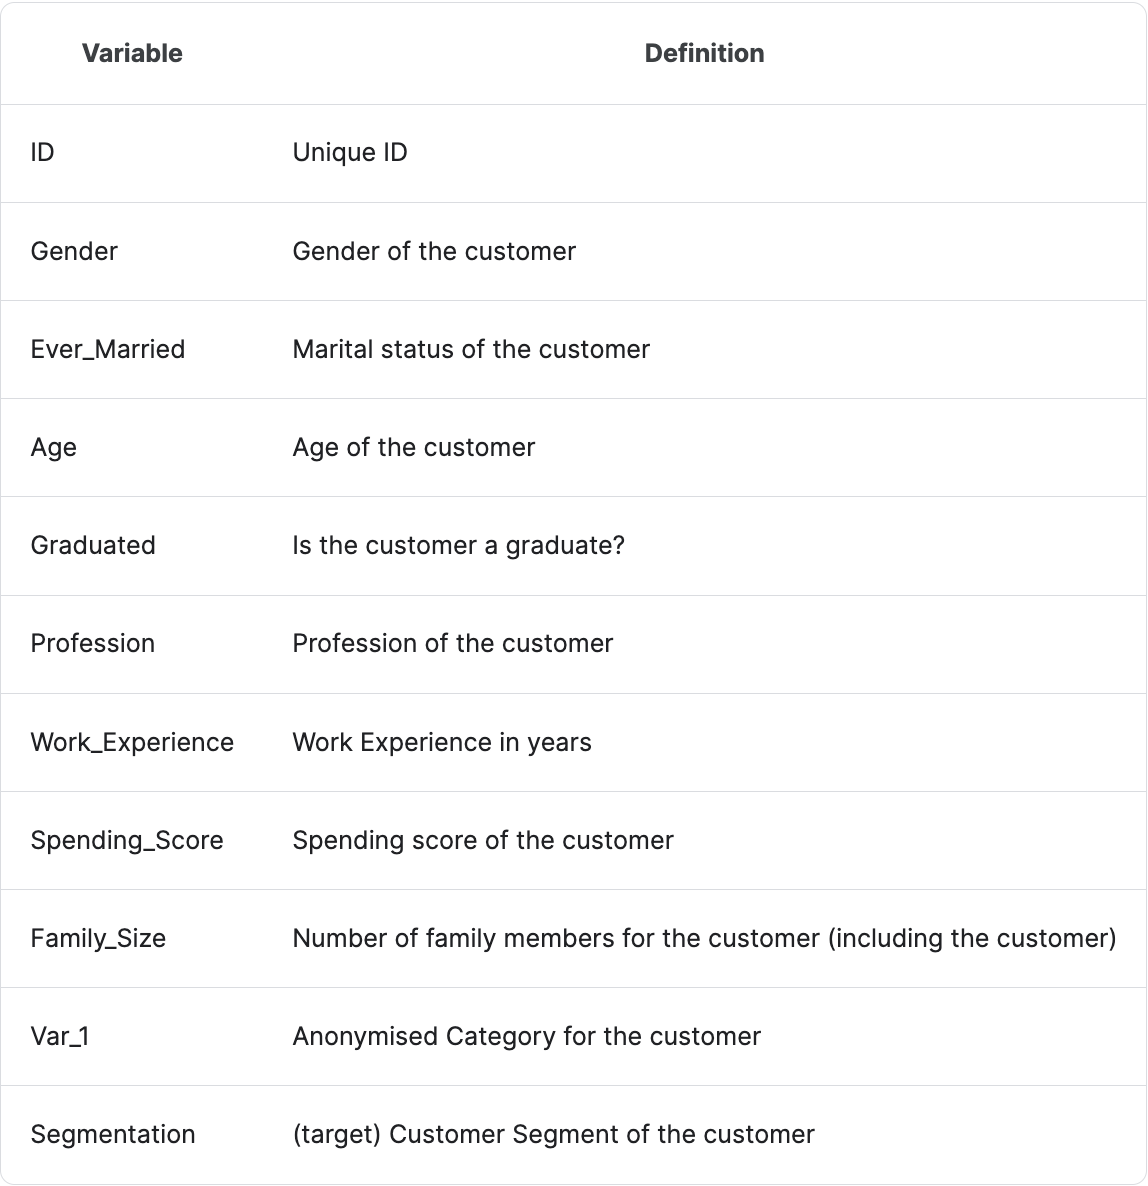









# Importing required Libraries and H20 Initialization

In [2]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [4]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 4.8 MB/s eta 0:00:00


In [5]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split as tts
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Perform Data Cleaning and Imputation

In [7]:
url = 'https://raw.githubusercontent.com/SangramSA/Data_Science/main/Train.csv'
data = pd.read_csv(url)
data.head()

ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0  462809    Male           No   22        No     Healthcare              1.0   
1  462643  Female          Yes   38       Yes       Engineer              NaN   
2  466315  Female          Yes   67       Yes       Engineer              1.0   
3  461735    Male          Yes   67       Yes         Lawyer              0.0   
4  462669  Female          Yes   40       Yes  Entertainment              NaN   

  Spending_Score  Family_Size  Var_1 Segmentation  
0            Low          4.0  Cat_4            D  
1        Average          3.0  Cat_4            A  
2            Low          1.0  Cat_6            B  
3           High          2.0  Cat_6            B  
4           High          6.0  Cat_6            A

In [8]:
# checking the shape of the dataframe
data.shape

(8068, 11)

In [10]:
# printing all the datatypes of respective columns
data.dtypes

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

In [11]:
# Checking null values
missing_values = data.isnull().sum()
missing_values

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [12]:
data.drop('ID', axis=1, inplace=True)

In [14]:
from sklearn.impute import KNNImputer

# Identifying numerical columns in the dataset
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Creating the KNN imputer instance
knn_imputer = KNNImputer(n_neighbors=5)

data[numerical_columns] = knn_imputer.fit_transform(data[numerical_columns])

In [15]:
from sklearn.preprocessing import OrdinalEncoder

# Identifying categorical columns in the dataset
categorical_columns = data.select_dtypes(include=['object']).columns

# Creating an ordinal encoder instance (KNNImputer works with numerical data, so we need to convert categorical data to numerical)
ordinal_encoder = OrdinalEncoder()

data[categorical_columns] = ordinal_encoder.fit_transform(data[categorical_columns])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   float64
 1   Ever_Married     7928 non-null   float64
 2   Age              8068 non-null   float64
 3   Graduated        7990 non-null   float64
 4   Profession       7944 non-null   float64
 5   Work_Experience  8068 non-null   float64
 6   Spending_Score   8068 non-null   float64
 7   Family_Size      8068 non-null   float64
 8   Var_1            7992 non-null   float64
 9   Segmentation     8068 non-null   float64
dtypes: float64(10)
memory usage: 630.4 KB


In [17]:
# Creating the KNN imputer instance
knn_imputer = KNNImputer(n_neighbors=5)

data[categorical_columns] = knn_imputer.fit_transform(data[categorical_columns])

In [18]:
data['Family_Size'] = data['Family_Size'].round()
data['Ever_Married'] = data['Ever_Married'].round()
data['Graduated'] = data['Graduated'].round()
data['Profession'] = data['Profession'].round()
data['Var_1'] = data['Var_1'].round()
for column in data:

    # Select column contents by column
    # name using [] operator
    columnSeriesObj = data[column]
    print('Column Name : ', column)
    print('Column Contents : ', data[column].value_counts())

Column Name :  Gender
Column Contents :  1.0    4417
0.0    3651
Name: Gender, dtype: int64
Column Name :  Ever_Married
Column Contents :  1.0    4727
0.0    3341
Name: Ever_Married, dtype: int64
Column Name :  Age
Column Contents :  35.0    250
37.0    234
33.0    232
42.0    232
40.0    229
       ... 
78.0     29
87.0     28
76.0     27
80.0     24
85.0     22
Name: Age, Length: 67, dtype: int64
Column Name :  Graduated
Column Contents :  1.0    5013
0.0    3055
Name: Graduated, dtype: int64
Column Name :  Profession
Column Contents :  0.0    2519
5.0    1346
3.0     967
2.0     721
1.0     714
4.0     634
7.0     623
8.0     292
6.0     252
Name: Profession, dtype: int64
Column Name :  Work_Experience
Column Contents :  1.0     2385
0.0     2318
9.0      474
8.0      463
2.0      326
3.0      279
4.0      267
6.0      215
7.0      204
5.0      202
0.8       59
0.6       58
3.8       56
10.0      53
11.0      50
12.0      48
2.2       47
13.0      46
14.0      45
2.8       43
1.2   

In [21]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

# Scaling the training data
data = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data.columns)

# Display the first few rows of the scaled training data
print(data.head())

   Gender  Ever_Married       Age  Graduated  Profession  Work_Experience  \
0     1.0           0.0  0.056338        0.0       0.625         0.071429   
1     0.0           1.0  0.281690        1.0       0.250         0.314286   
2     0.0           1.0  0.690141        1.0       0.250         0.071429   
3     1.0           1.0  0.690141        1.0       0.875         0.000000   
4     0.0           1.0  0.309859        1.0       0.375         0.528571   

   Spending_Score  Family_Size     Var_1  Segmentation  
0             1.0        0.375  0.500000      1.000000  
1             0.0        0.250  0.500000      0.000000  
2             1.0        0.000  0.833333      0.333333  
3             0.5        0.125  0.833333      0.333333  
4             0.5        0.625  0.833333      0.000000  


In [22]:
data.head()

Gender  Ever_Married       Age  Graduated  Profession  Work_Experience  \
0     1.0           0.0  0.056338        0.0       0.625         0.071429   
1     0.0           1.0  0.281690        1.0       0.250         0.314286   
2     0.0           1.0  0.690141        1.0       0.250         0.071429   
3     1.0           1.0  0.690141        1.0       0.875         0.000000   
4     0.0           1.0  0.309859        1.0       0.375         0.528571   

   Spending_Score  Family_Size     Var_1  Segmentation  
0             1.0        0.375  0.500000      1.000000  
1             0.0        0.250  0.500000      0.000000  
2             1.0        0.000  0.833333      0.333333  
3             0.5        0.125  0.833333      0.333333  
4             0.5        0.625  0.833333      0.000000

In [29]:
X=data.drop(['Segmentation'],axis=1)
y=data['Segmentation']

In [30]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.2,random_state=42)

In [31]:
#Calculating VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]

print(vif_data)

           feature       VIF
0           Gender  2.223519
1     Ever_Married  4.859396
2              Age  5.852788
3        Graduated  2.995340
4       Profession  2.612029
5  Work_Experience  1.675151
6   Spending_Score  4.338720
7      Family_Size  2.309184
8            Var_1  7.446975


In [32]:
cols= ['Gender','Ever_Married', 'Age','Graduated','Profession', 'Work_Experience', 'Spending_Score', 'Family_Size','Var_1']
model = sm.OLS(y_train,sm.add_constant(X_train[cols])).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Segmentation   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     113.4
Date:                Fri, 15 Mar 2024   Prob (F-statistic):          3.45e-198
Time:                        19:50:30   Log-Likelihood:                -2421.3
No. Observations:                6454   AIC:                             4863.
Df Residuals:                    6444   BIC:                             4930.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5427      0.024     

In [33]:
data=data.drop(['Work_Experience'],axis=1)

Text(0.5, 1.0, 'Variable Correlation')

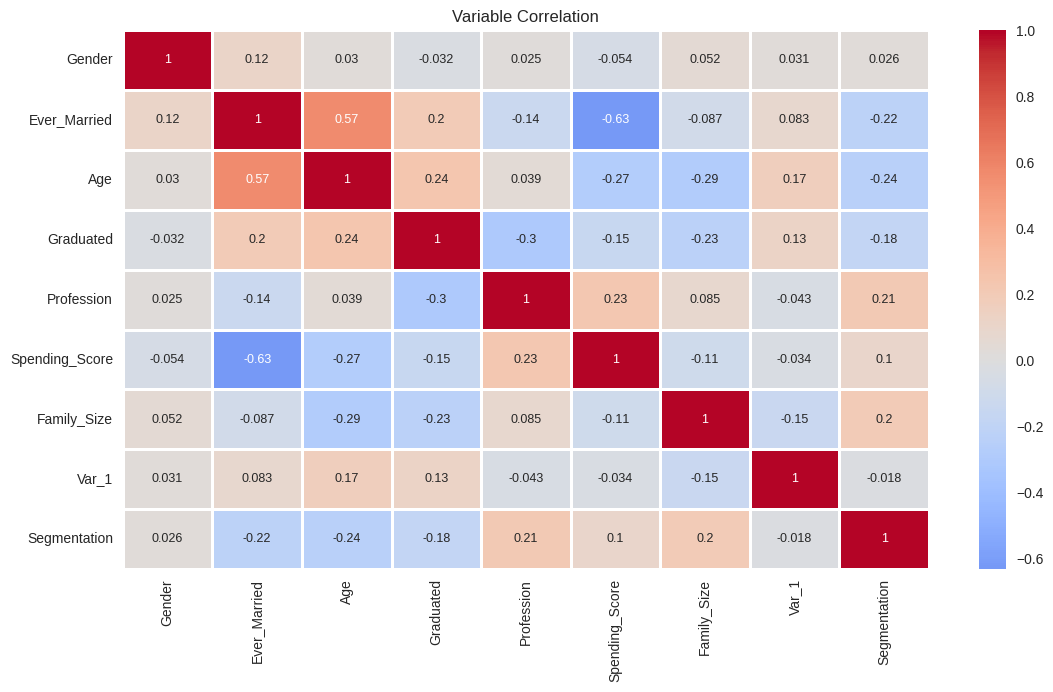

In [34]:
from IPython.core.pylabtools import figsize
f,ax=plt.subplots(figsize=(13,7))

sns.heatmap(data.corr(),center=0, linewidths=0.9,cmap='coolwarm',annot=True, annot_kws={"size": 9})
plt.title('Variable Correlation')

# Perform Linear Regression

In [35]:
#Computing Linear Regression model for BigMart dataset
def linear_reg(X_train,y_train,X_test,y_test):
    linear_reg = LinearRegression()
    linear_reg_model = linear_reg.fit(X_train,y_train)
    print('Train set')
    pred=linear_reg_model.predict(X_train)
    print('Linear Regression Mean Squared error :{}'.format(mean_squared_error(y_train,pred)))
    print('Linear Regression r2_score :{}'.format(r2_score(y_train,pred)))
    print('Test set')
    pred=linear_reg_model.predict(X_test)
    model_lr=linear_reg_model.predict(X_test)
    print('Linear Regression Mean Squared error :{}'.format(mean_squared_error(y_test,pred)))
    print('Linear Regression r2_score :{}'.format(r2_score(y_test,pred)))

In [36]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [37]:
cols1= ['Gender','Ever_Married', 'Age','Graduated','Profession', 'Spending_Score', 'Family_Size','Var_1']

In [38]:
#Computing R2 for testing and training data
linear_reg(X_train[cols1],y_train,X_test[cols1],y_test)

Train set
Linear Regression Mean Squared error :0.12400822312387688
Linear Regression r2_score :0.13655086618628232
Test set
Linear Regression Mean Squared error :0.12934310759276454
Linear Regression r2_score :0.11502015539144494


# SHAP Analysis on Linear Regression model

In [39]:
%%capture
!pip install shap
import shap

In [40]:
import shap
shap.initjs()

In [41]:
# Giving input as 1% of whole dataset as SHAP cant handle large dataset
X = X_train.sample(frac=0.01,random_state=200)
#LinearExplainer is used as linear regression model is used
explainer = shap.LinearExplainer(model, X, feature_perturbation="interventional")
shap_values = explainer.shap_values(X) #Saving SHAP values

In [42]:
#Initialize java script
shap.initjs()

 #Explain one row in the data with the
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

In [44]:
#Initializing explainer from shap, lm is our trained model
explainer_shap=shap.LinearExplainer(model=model, masker=X_train)

#Computing shap values for train dataset
shap_values = explainer_shap.shap_values(X_train)

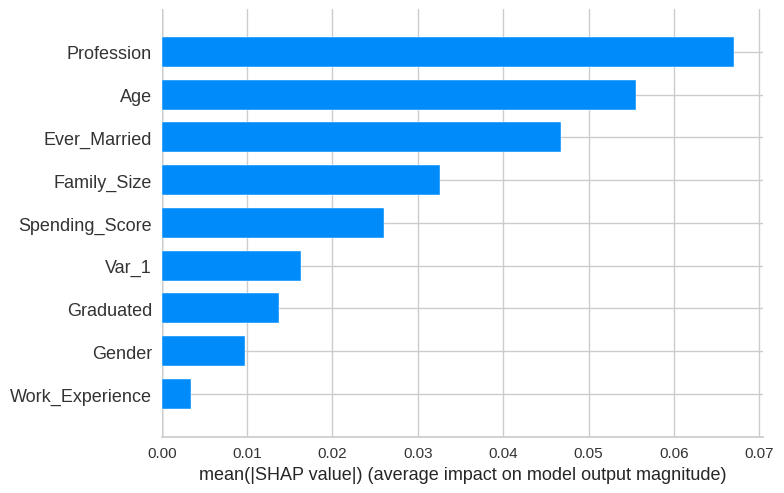

In [45]:
shap.summary_plot(shap_values, X, plot_type="bar")

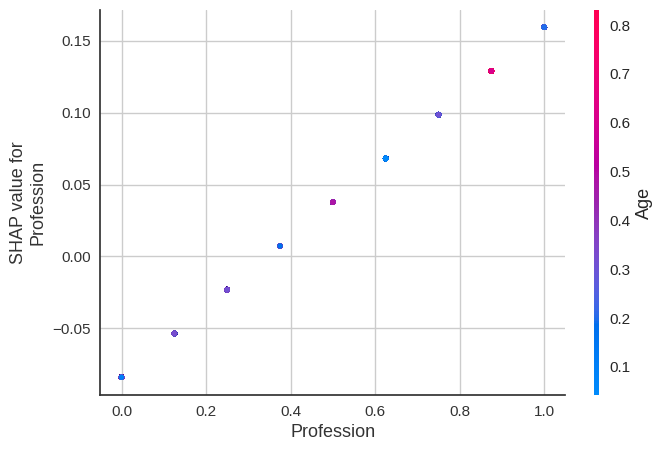

In [46]:
shap.dependence_plot("Profession", shap_values, X_train)

In [47]:
from sklearn.linear_model import LinearRegression
import shap

# train Linear model
#Seperating the dependent and independent variable from the main dataset
X=data.drop(['Segmentation'],axis=1)
y=data['Segmentation']
regressor = LinearRegression()
linear_reg = regressor.fit(X, y)

# compute SHAP values
explainer = shap.Explainer(linear_reg, X)
shap_values = explainer(X)

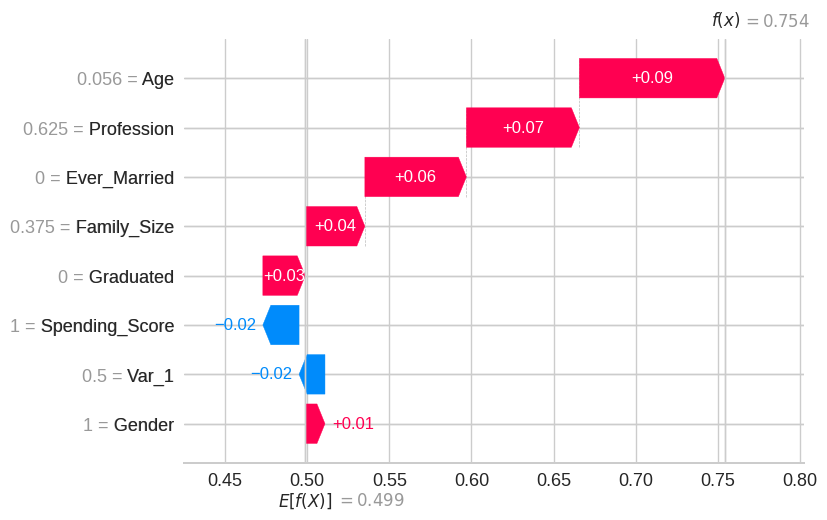

In [48]:
shap.plots.waterfall(shap_values[0])

For the linear regression model from the plots it can be interpreted that Profession, Age, Ever_Married are the important features for this regressor model. These are the major features in determining the Segmentation.

# RANDOM FOREST

In [49]:
def ramdomforest(X_train,y_train,X_test,y_test):
    rf = RandomForestRegressor()
    rf_model = rf.fit(X_train,y_train)
    print('Train set')
    pred=rf_model.predict(X_train)
    print('ramdomforest Mean Squared error :{}'.format(mean_squared_error(y_train,pred)))
    print('ramdomforest r2_score :{}'.format(r2_score(y_train,pred)))
    print('Tesst set')
    pred=rf_model.predict(X_test)
    print('ramdomforest Mean Squared error :{}'.format(mean_squared_error(y_test,pred)))
    print('ramdomforest r2_score :{}'.format(r2_score(y_test,pred)))

random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, y_train)

RandomForestRegressor()

In [50]:
ramdomforest(X_train[cols1],y_train,X_test[cols1],y_test)

Train set
ramdomforest Mean Squared error :0.03059770181690238
ramdomforest r2_score :0.7869531675806434
Tesst set
ramdomforest Mean Squared error :0.13403799900324873
ramdomforest r2_score :0.08289718921078126


# SHAP Analysis on Random Forest Model

In [51]:
%%capture
!pip install shap
import shap

In [52]:
# Giving input as 1% of whole dataset as SHAP cant handle large dataset
X = X_train.head(10)
 # Using Tree explainer as this is tree based classifier model
explainer = shap.TreeExplainer(random_forest)
#Saving shap values
shap_values = explainer.shap_values(X)

In [53]:
shap.initjs() #Initialize java script
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:]) #Explain one row in the data with the model

In [54]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

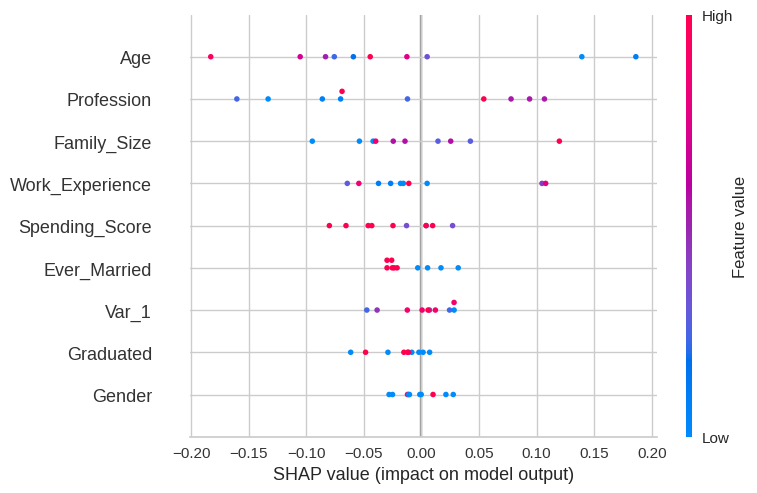

In [55]:
shap.initjs()
shap.summary_plot(shap_values, X)

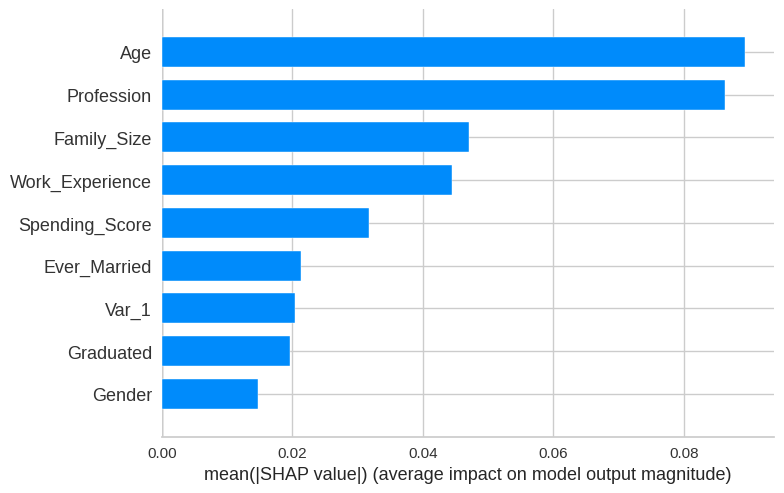

In [56]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
iris = load_iris()

model_rf1 = RandomForestRegressor(n_estimators=10)
# Train
model_rf1.fit(iris.data, iris.target)
# Extract single tree
estimator = model_rf1.estimators_[5]

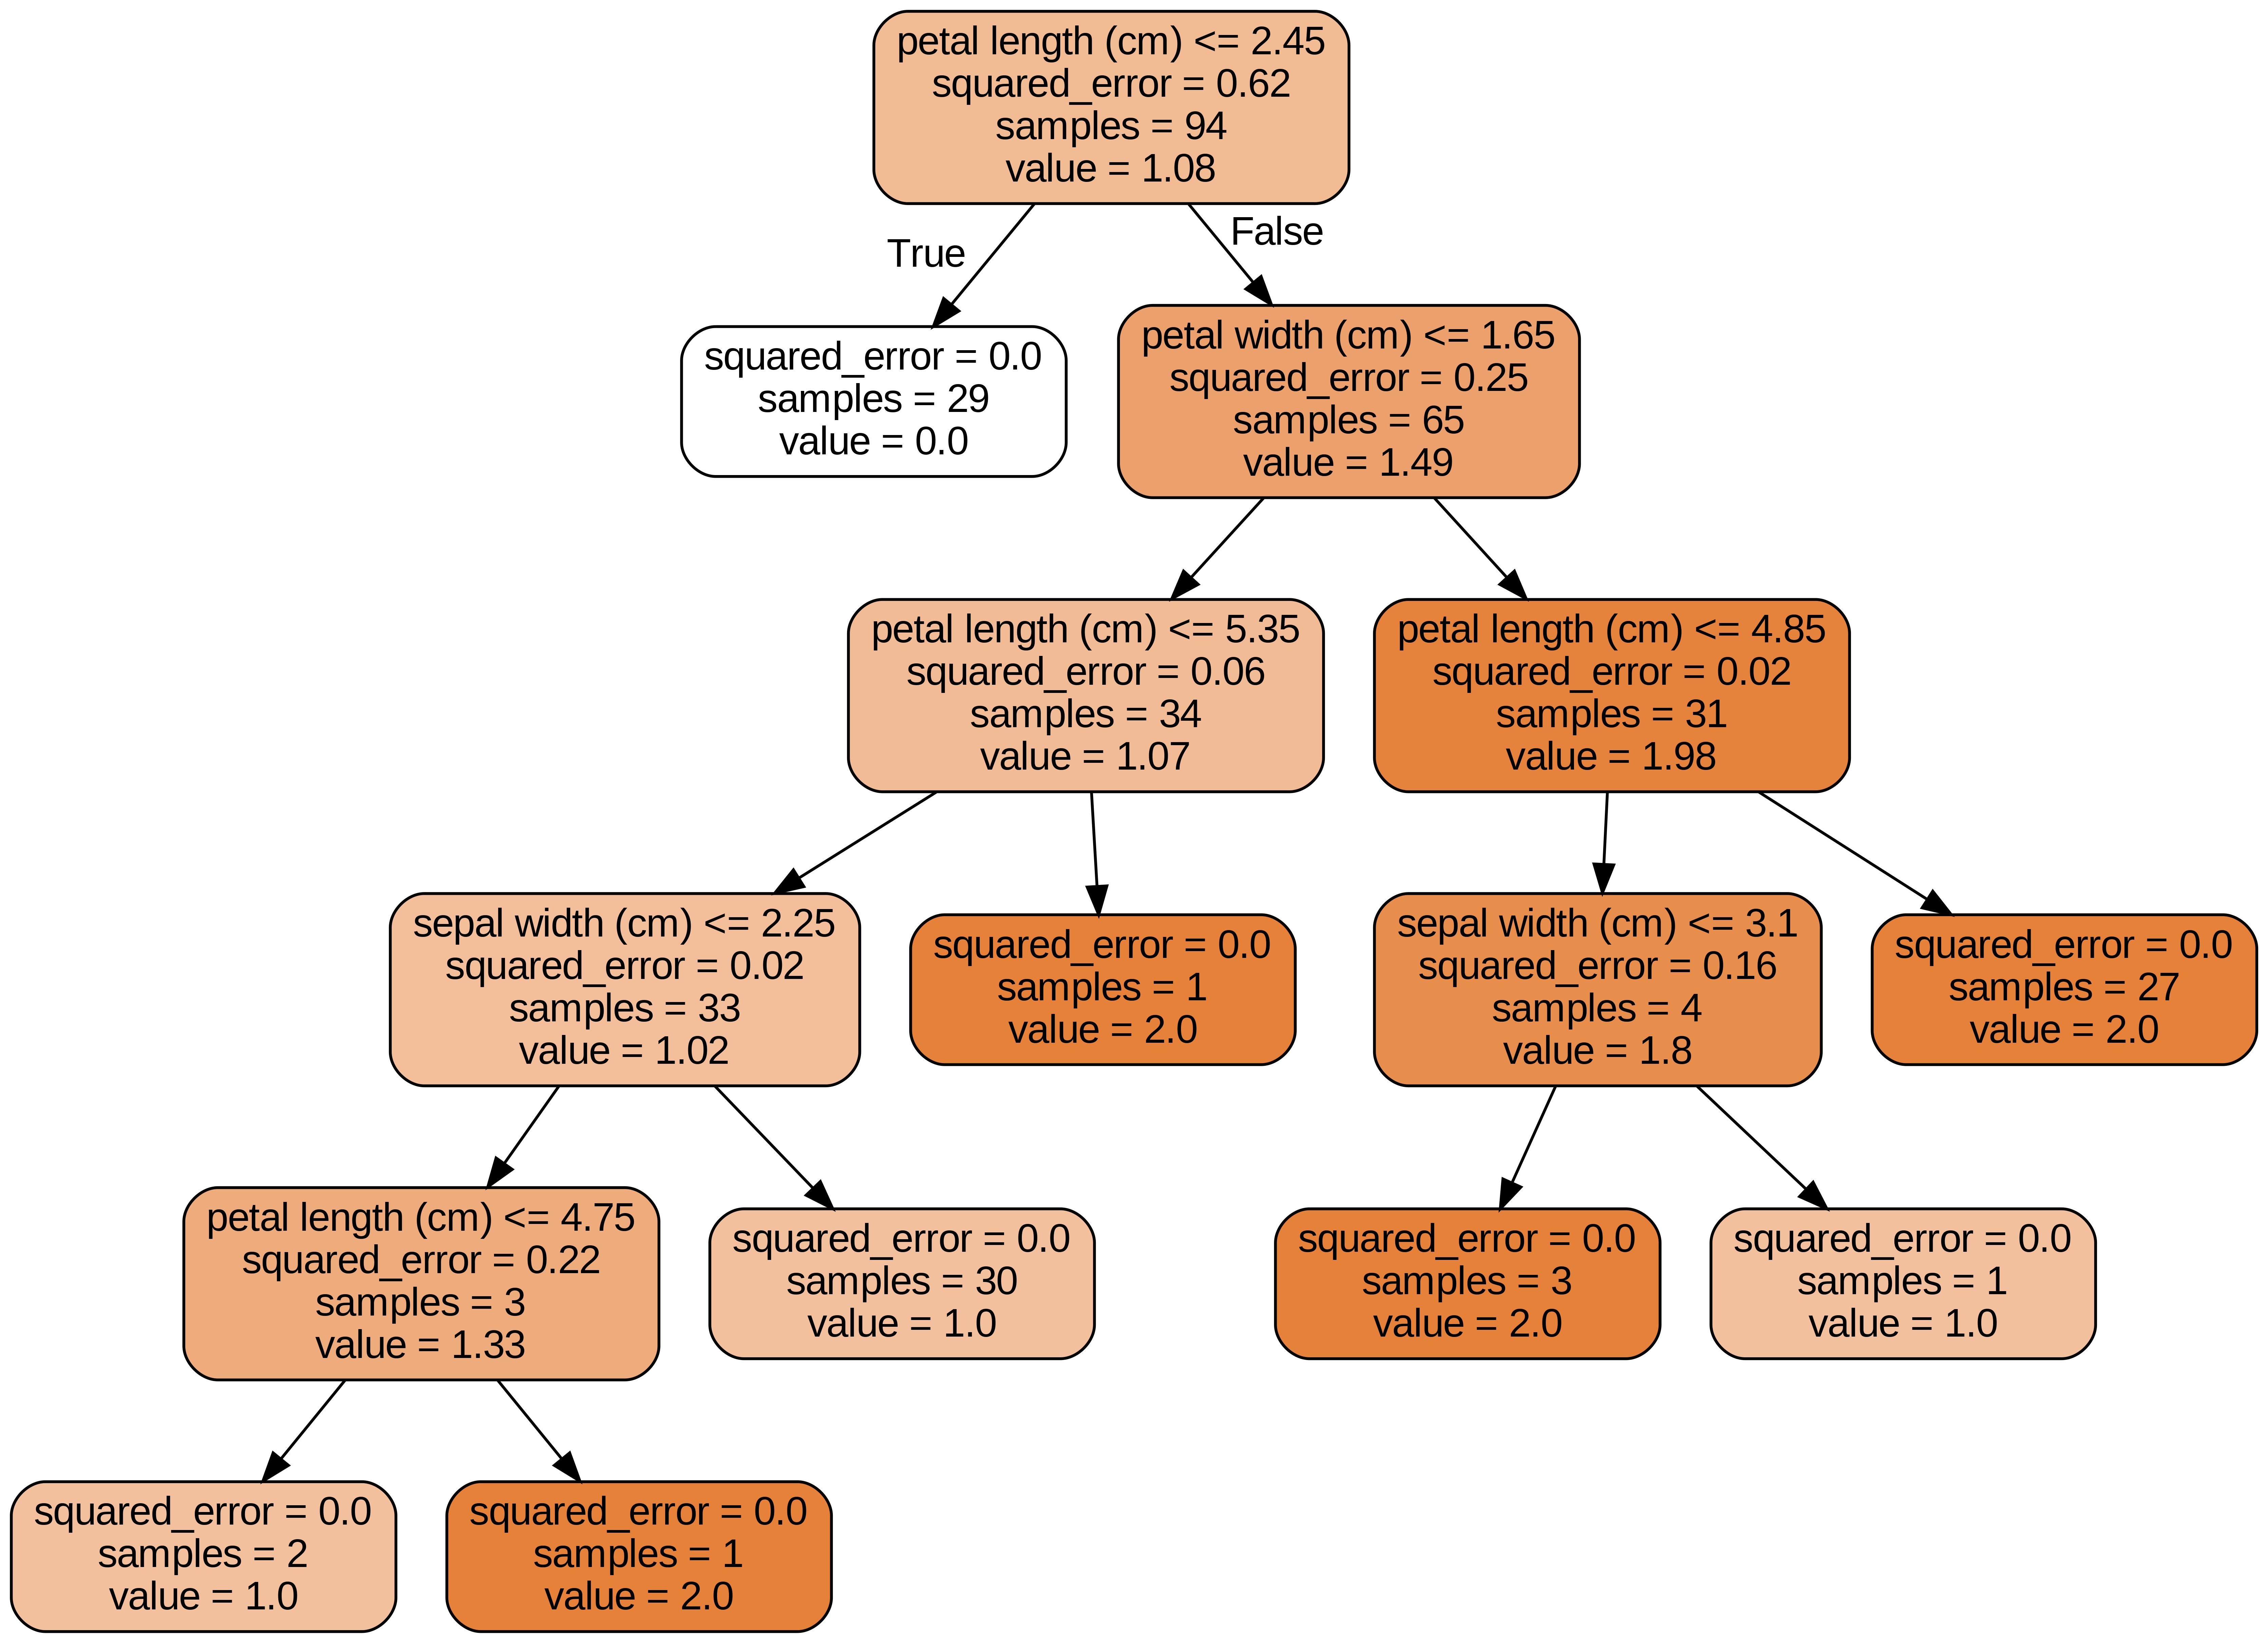

In [58]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot',
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False,
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in colab notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Using AutoML to identify best model

In [59]:
#importing all the necessary libraries

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import numpy as np
import scipy

In [60]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6
run_time=222

In [61]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


In [62]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:27610..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpeoaxn_8k
  JVM stdout: /tmp/tmpeoaxn_8k/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpeoaxn_8k/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:27610
Connecting to H2O server at http://127.0.0.1:27610 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    2 days
H2O_cluster_name:           H2O_from_python_unknownUser_5kpd2m
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:27610
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [78]:
data['Segmentation'] = data['Segmentation'].astype(int)

In [79]:
# splitting the  data into X and y variables where X is independent variables and y is target variable
X = data.drop(['Segmentation'],axis=1)
y = data['Segmentation']

In [80]:
# splitting the data into train and test split
from sklearn.model_selection import train_test_split

# splitting the data into train and test in the ratio 80:20
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

In [81]:
train = pd.concat([X_train,y_train],axis=1,keys=['X_train','y_train'])
test = pd.concat([X_test,y_test],axis=1,keys=['X_test','y_test'])

In [82]:
train.columns = train.columns.droplevel(0)
test.columns = test.columns.droplevel(0)

In [83]:
# creating a train and test H2O frame
hf = h2o.H2OFrame(train)
test_hf = h2o.H2OFrame(test)
hf.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Gender    Ever_Married       Age    Graduated    Profession    Spending_Score    Family_Size     Var_1    Segmentation
--------  --------------  --------  -----------  ------------  ----------------  -------------  --------  --------------
       0               1  0.28169             1         0.125               1            0.375  0.333333               0
       0               0  0.211268            0         0.25                1            0.5    0.333333               1
       0               1  0.43662             0         0.25                1            0      1                      0
       0               0  0.112676            0         0.5                 1            0.25   0.833333               1
       0               0  0.535211            1         0.125               1            0      0.833333               0
       0               1  0.338028            0         0.5                 0            0.125  0.5                    1
       1               1  0.732394            0         0.875               0.5          0.25   0                      0
       0               1  0.661972            1         0.875               1            0      0.833333               0
       1               1  0.56338             0         0.5                 0.5          0.125  0.833333               0
       0               0  0.253521            1         0                   1            0.25   0.5                    0
[10 rows x 9 columns]

In [84]:
hf.columns

['Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Profession',
 'Spending_Score',
 'Family_Size',
 'Var_1',
 'Segmentation']

In [85]:
hf.types

{'Gender': 'int',
 'Ever_Married': 'int',
 'Age': 'real',
 'Graduated': 'int',
 'Profession': 'real',
 'Spending_Score': 'real',
 'Family_Size': 'real',
 'Var_1': 'real',
 'Segmentation': 'int'}

In [86]:
# setting up the dataset to split into train and test H2Oframe
hf['Segmentation'] = hf['Segmentation'].asfactor()
predictors = hf.drop('Segmentation').columns
response = 'Segmentation'

In [87]:
train_hf,val_hf = hf.split_frame(ratios=[.8],seed=1234)

In [88]:
aml = H2OAutoML(max_models=10,max_runtime_secs=300,seed=1234,exclude_algos = ["DeepLearning"])

In [89]:
aml.train(x=predictors,y=response,training_frame=hf)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20240315_202549


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    56                 56                          28911                  7            15           9.57143       32            42            36.4286

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10885763490726907
RMSE: 0.32993580422147134
LogLoss: 0.33820843964871
Mean Per-Class Error: 0.18907086568963785
AUC: 0.9041886163224099
AUCPR: 0.8056570138708932
Gini: 0.8083772326448198

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38366552633739176
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      4020  640   0.1373   (640.0/4660.0)
1      432   1362  0.2408   (432.0/1794.0)
Total  4452  2002  0.1661   (1072.0/6454.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383666     0.717597  191
max f2                       0.177385     0.804994  281
max f0point5                 0.557285     0.729518  120
max accuracy                 0.499844     0.839944  140
max precision                0.972517     1         0
max recall                   0.0213234    1         379
max specificity              0.972517     1         0
max absolute_mcc             0.383666     0.602263  191
max min_per_class_accuracy   0.308676     0.816524  222
max mean_per_class_accuracy  0.291295     0.819349  230
max tns                      0.972517     4660      0
max fns                      0.972517     1789      0
max fps                      0.00244946   4660      399
max tps                      0.0213234    1794      379
max tnr                      0.972517     1         0
max fnr                      0.972517     0.997213  0
max fpr                      0.00244946   1         399
max tpr                      0.0213234    1         379

Gains/Lift Table: Avg response rate: 27.80 %, avg score: 27.79 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0102262                   0.96877            3.59755    3.59755            1                0.970362    1                           0.970362            0.0367893       0.0367893                  259.755   259.755            0.0367893
2        0.0212271                   0.964157           3.59755    3.59755            1                0.966587    1                           0.968405            0.0395764       0.0763657                  259.755   259.755            0.0763657
3        0.0303688                   0.961272           3.59755    3.59755            1                0.961951    1                           0.966463            0.0328874       0.109253                   259.755   259.755            0.109253
4        0.040595                    0.9568             3.59755    3.59755            1                0.95844     1                           0.964442            0.0367893       0.146042                   259.755   259.755            0.146042
5        0.0502014                   0.952569           3.59755    3.59755            1                0.9549      1                 

The above results suggest the following:

The best model that fits our data is Stacked Ensemble with total of 5 base models including GBM,XGBoost, GLM, and DRF. It also inlcluded metalearner as GLM. The model gives an train AUC of 0.94 and val AUC of 0.89. The f1 score for train and test are 0.786 and 0.68 suggesting that precision and recall have a good balance in both train and val. Hence the model does not overfit the data. The train and val MSE are 0.088 and 0.119 which are respectable values suggesting the model fits the data well and it makes sense. Also the data is able to very nicely handle data imbalance. It is not biased towards the class with people having any specific segment.

In [90]:
# printing the leaderboard of top 10 models
lb = aml.leaderboard
lb

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  --------
GBM_1_AutoML_1_20240315_202549                           0.878707   0.371838  0.763646                0.211569  0.346992  0.120404
StackedEnsemble_AllModels_1_AutoML_1_20240315_202549     0.878218   0.369989  0.764045                0.203225  0.346556  0.120101
StackedEnsemble_BestOfFamily_1_AutoML_1_20240315_202549  0.878207   0.369994  0.763231                0.205388  0.346649  0.120166
GBM_2_AutoML_1_20240315_202549                           0.87601    0.374702  0.763309                0.205711  0.348243  0.121273
XGBoost_3_AutoML_1_20240315_202549                       0.874764   0.374915  0.759939                0.206575  0.349599  0.122219
GBM_3_AutoML_1_20240315_202549                           0.874424   0.376121  0.761874                0.207388  0.349075  0.121854
GBM_4_AutoML_1_20240315_202549                           0.871879   0.381778  0.757112                0.212552  0.351588  0.123614
XGBoost_1_AutoML_1_20240315_202549                       0.871419   0.382491  0.755606                0.213834  0.352635  0.124351
XGBoost_2_AutoML_1_20240315_202549                       0.870708   0.384758  0.755567                0.213948  0.353973  0.125297
XRT_1_AutoML_1_20240315_202549                           0.869278   0.393906  0.752583                0.21116   0.354112  0.125396
[12 rows x 7 columns]

Above table describes the top 10 models according to the AUC and other metrics. We will be fetching two models from the table for further analysis.

# Finding the best model and performing some analysis


In [91]:
#assign index values to all the models generated
model_index=0
index=0
gbm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break
  model_index=model_index+1

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=index
    break
  index=index+1
models_dict

{'GBM_1_AutoML_1_20240315_202549': 0, 'GLM_1_AutoML_1_20240315_202549': 10}

In [96]:
#print the index value of best model
print(model_index)
best_model1 = h2o.get_model(aml.leaderboard[model_index,'model_id'])

0


In [98]:
best_model1.algo

'gbm'

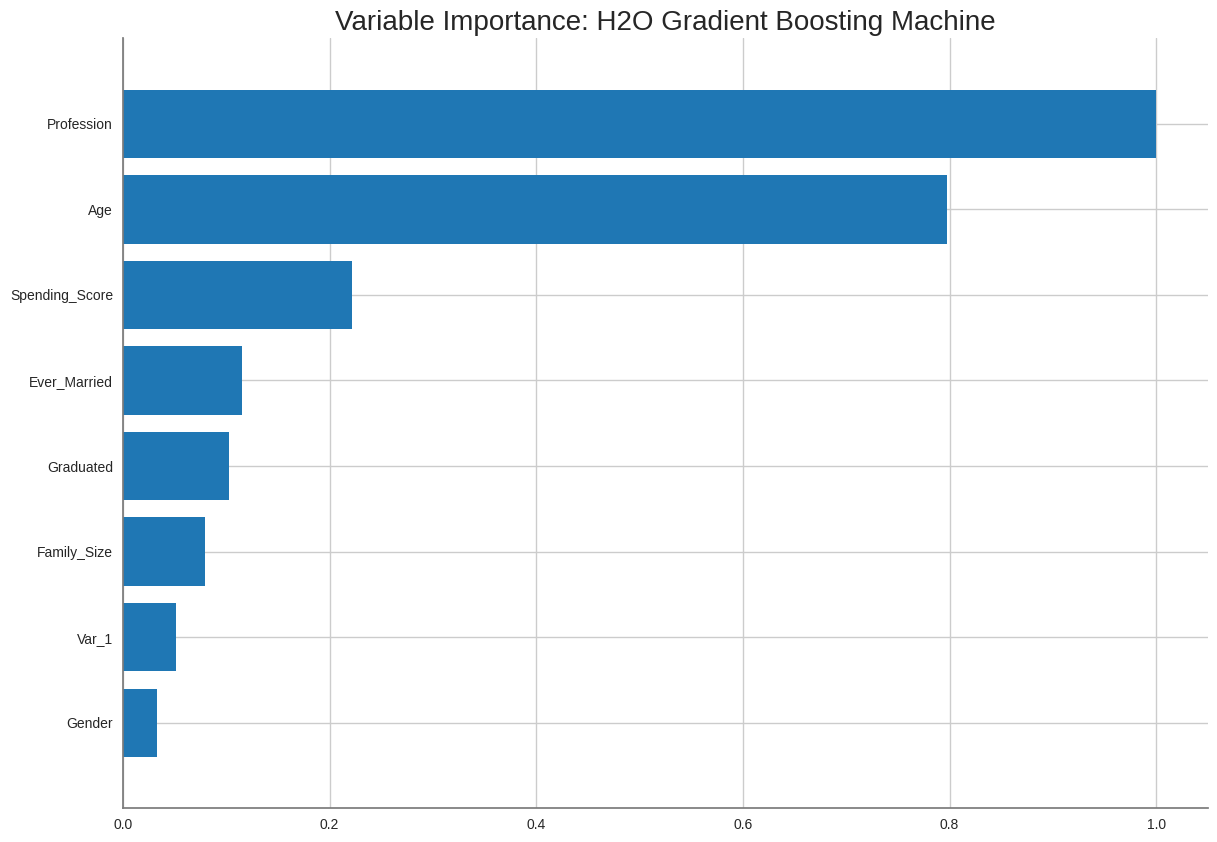

<Figure size 800x550 with 0 Axes>

In [99]:
#plot variables in order of their importance for price prediction
if best_model1.algo in ['gbm','drf','xrt','xgboost']:
    best_model1.varimp_plot()

10
glm


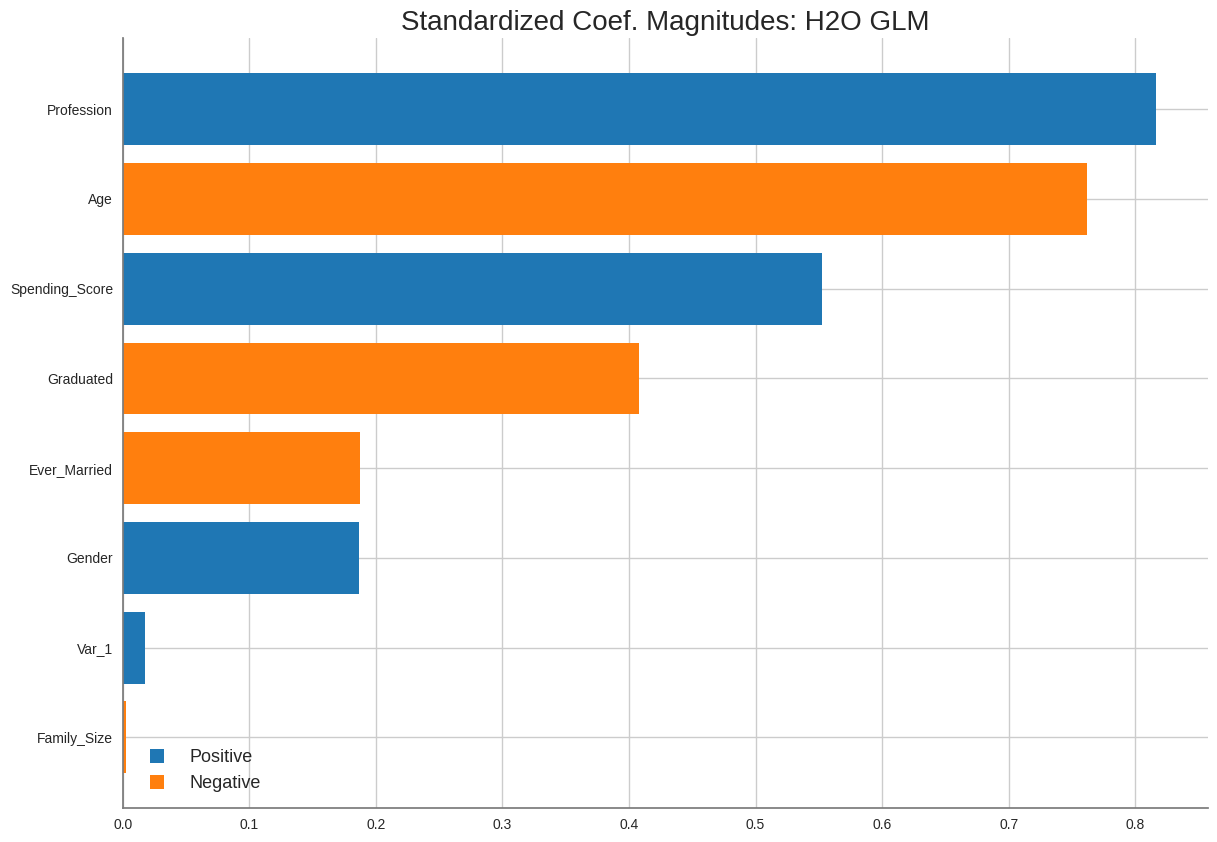

In [100]:
if index is not 0:
  print(index)
  gbm_model1=h2o.get_model(aml.leaderboard[index,'model_id'])
  print(gbm_model1.algo)
  gbm_model1.std_coef_plot()

# SHAP Analysis on AutoML model

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  --------  ------------------  -------------------------  ---------------
StackedEnsemble_AllModels_1_AutoML_1_20240315_202549     0.881889   0.372843  0.784403                0.19879   0.34831   0.12132                12012                   0.178235  StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20240315_202549  0.881699   0.372993  0.784043                0.20206   0.348166  0.121219               11824                   0.071431  StackedEnsemble
GBM_2_AutoML_1_20240315_202549                           0.881343   0.377451  0.780322                0.195237  0.350393  0.122775                1106                   0.032099  GBM
GBM_1_AutoML_1_20240315_202549                           0.879663   0.37854   0.779185                0.200222  0.35044   0.122808                2320                   0.024771  GBM
XGBoost_3_AutoML_1_20240315_202549                       0.879574   0.376432  0.783467                0.198223  0.34979   0.122353                 904                   0.016594  XGBoost
GBM_3_AutoML_1_20240315_202549                           0.877688   0.380499  0.776864                0.202476  0.352246  0.124077                 816                   0.037711  GBM
XGBoost_2_AutoML_1_20240315_202549                       0.87605    0.387257  0.773633                0.210843  0.356505  0.127096                1297                   0.015369  XGBoost
GBM_4_AutoML_1_20240315_202549                           0.875028   0.387354  0.770785                0.197463  0.354975  0.126007                 963                   0.031241  GBM
XGBoost_1_AutoML_1_20240315_202549                       0.874919   0.384875  0.771784                0.193044  0.354461  0.125643                1213                   0.010428  XGBoost
XRT_1_AutoML_1_20240315_202549                           0.871722   0.400113  0.77272                 0.212808  0.357373  0.127716                1101                   0.024856  DRF
DRF_1_AutoML_1_20240315_202549                           0.860808   0.441786  0.755861                0.226194  0.36752   0.135071                2129                   0.033079  DRF
GLM_1_AutoML_1_20240315_202549                           0.857694   0.41918   0.699781                0.220225  0.365765  0.133784                 386                   0.007333  GLM
[12 rows x 10 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

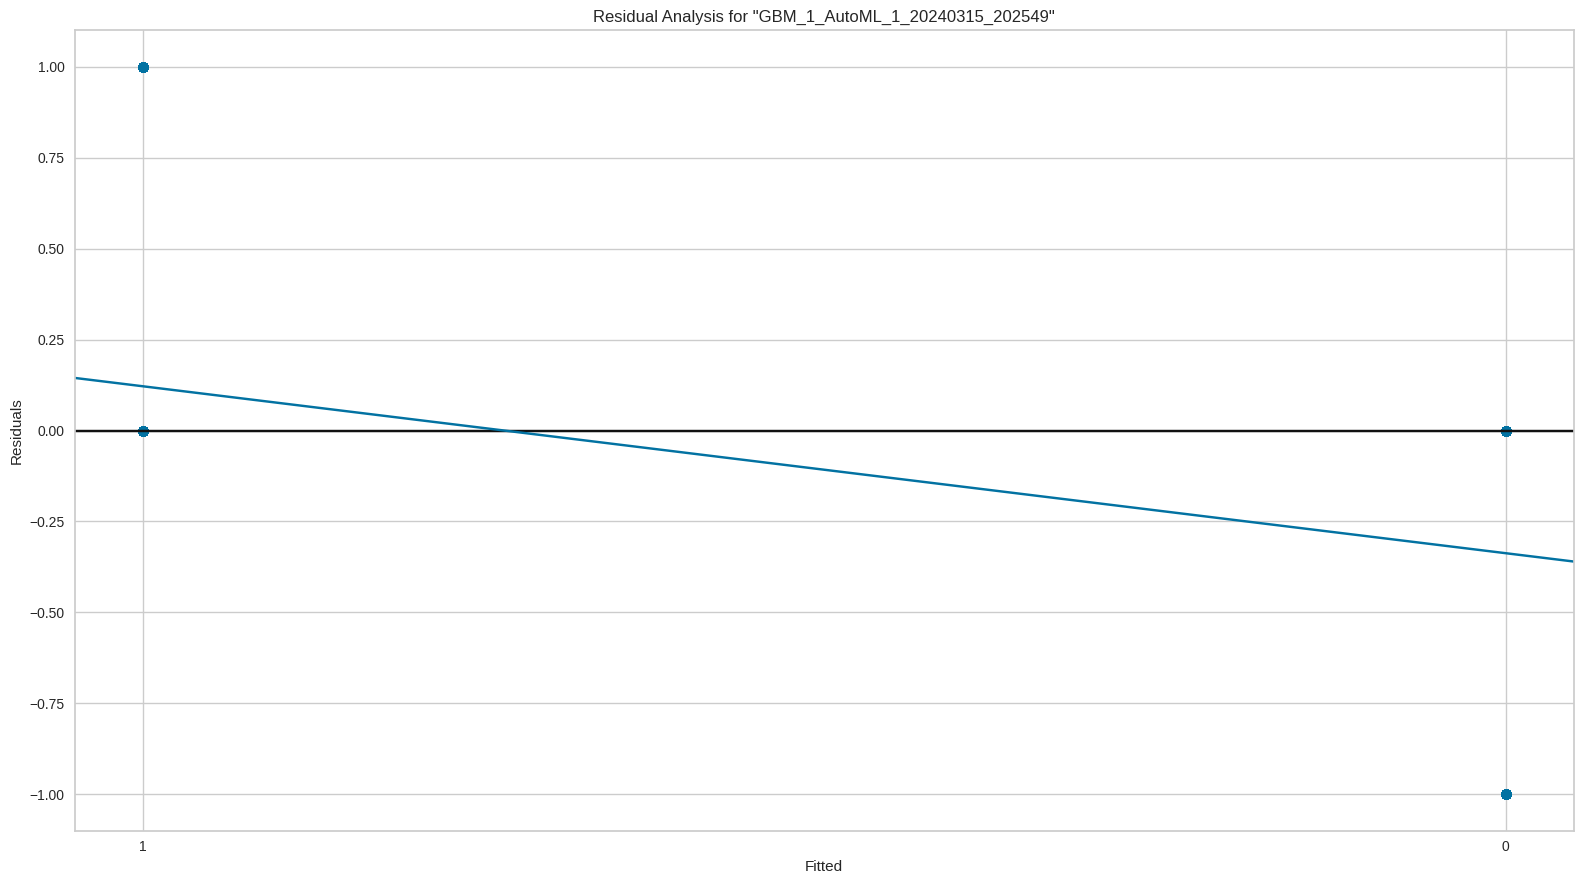

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

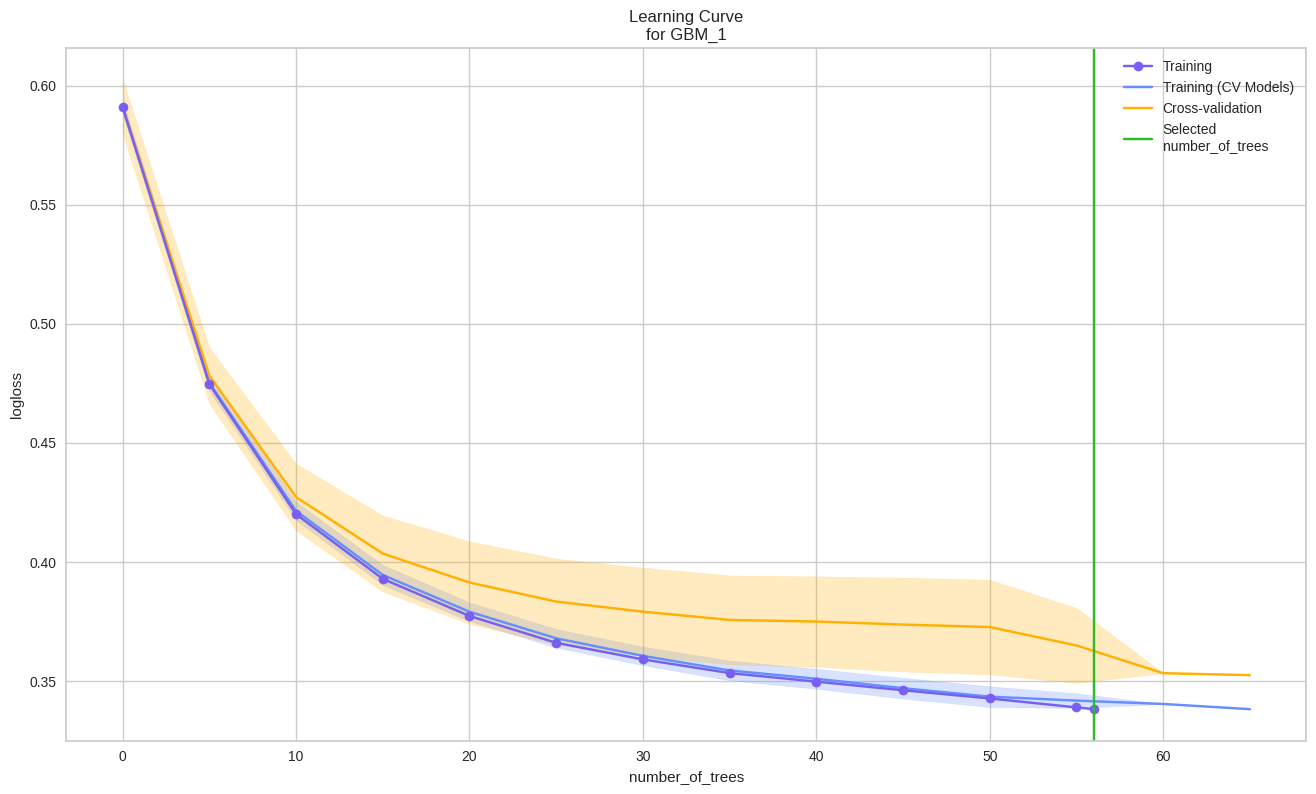

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

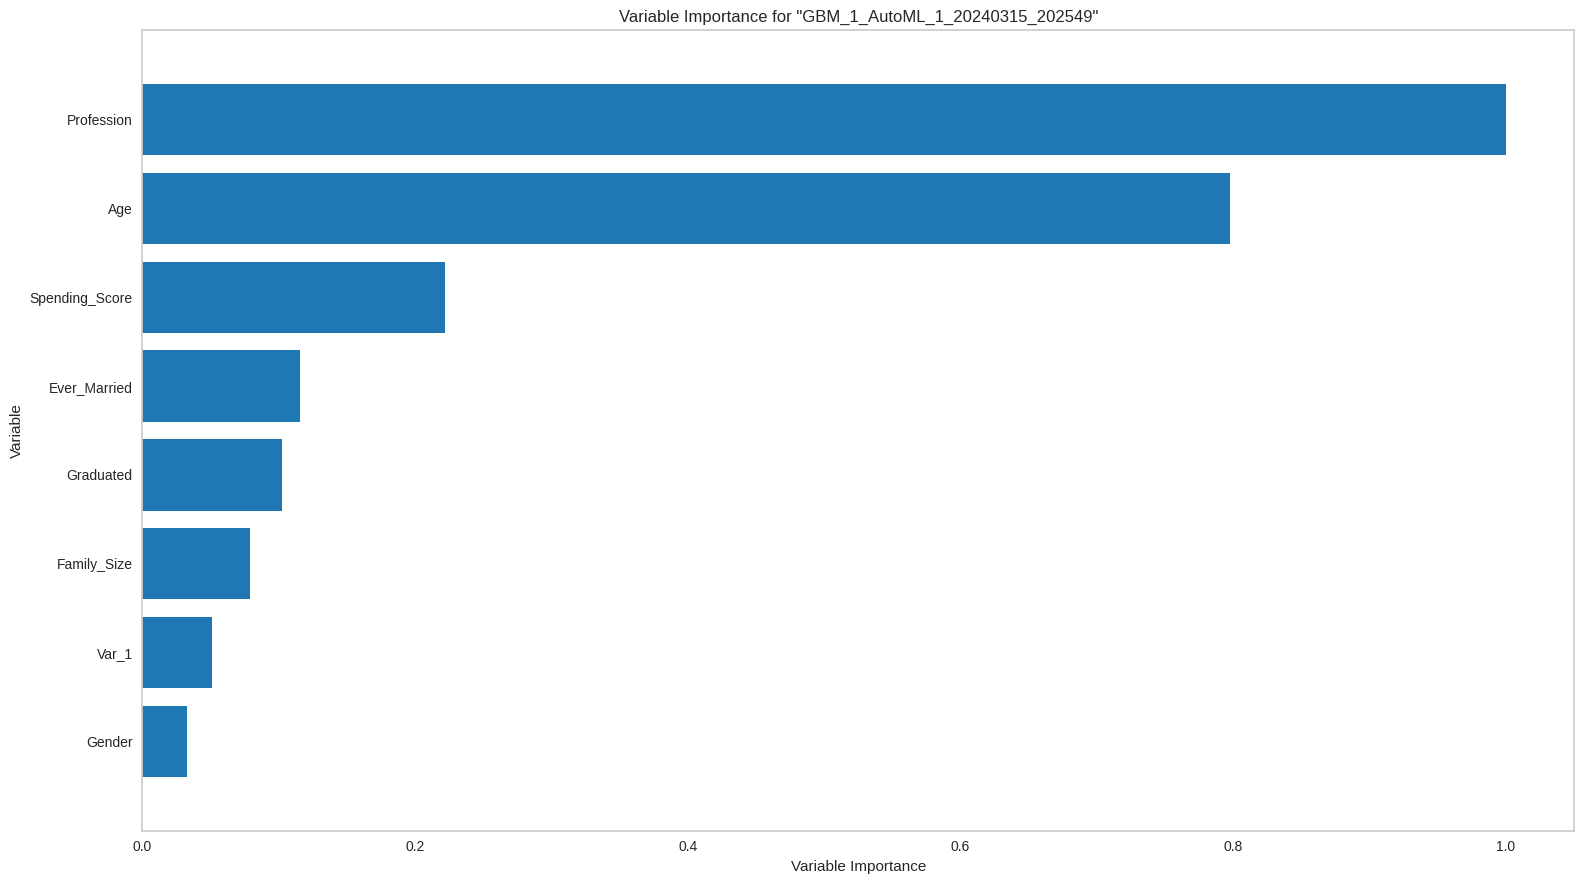

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

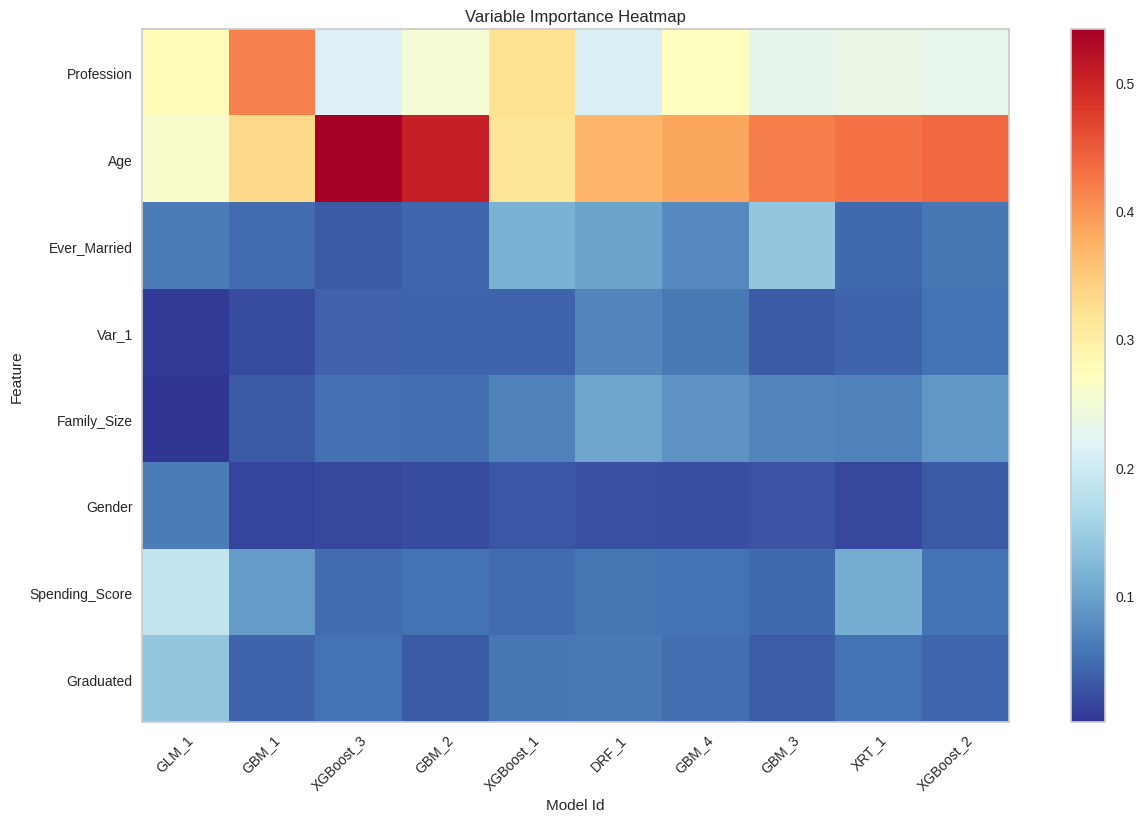

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

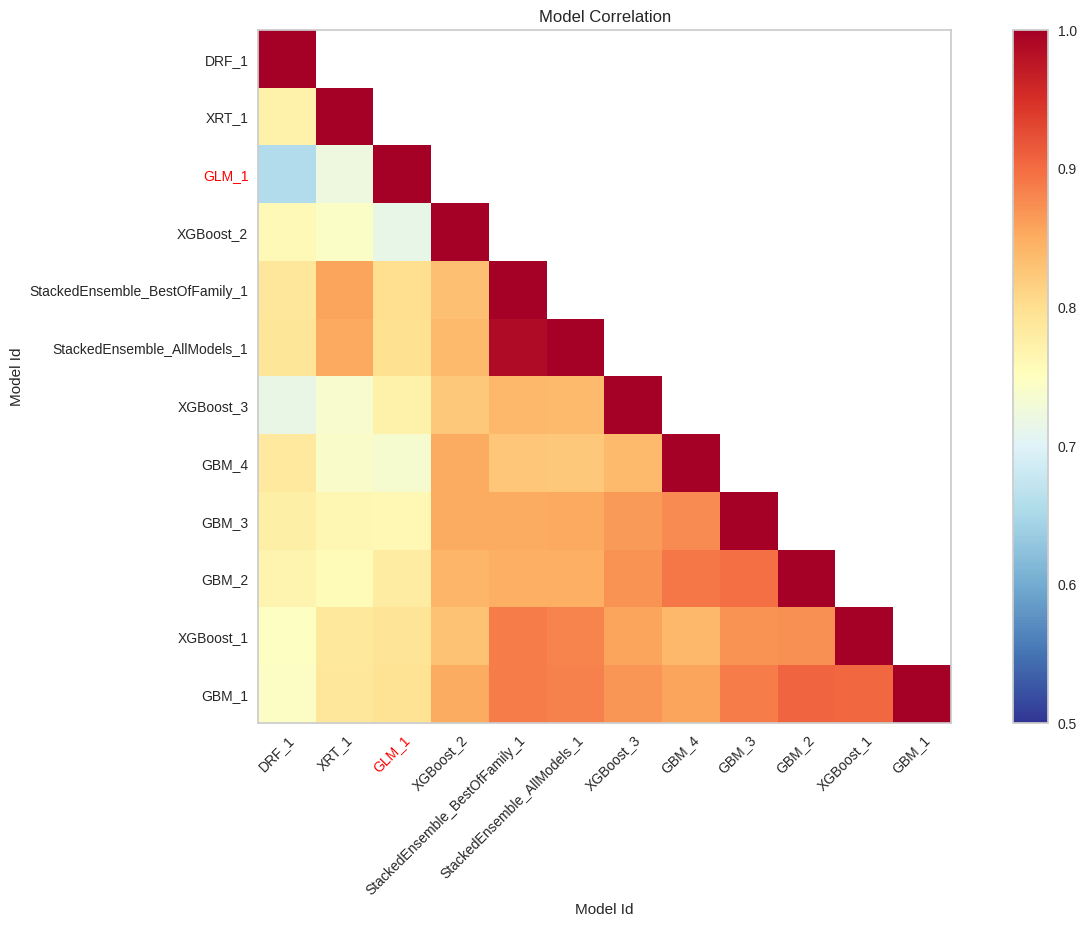

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

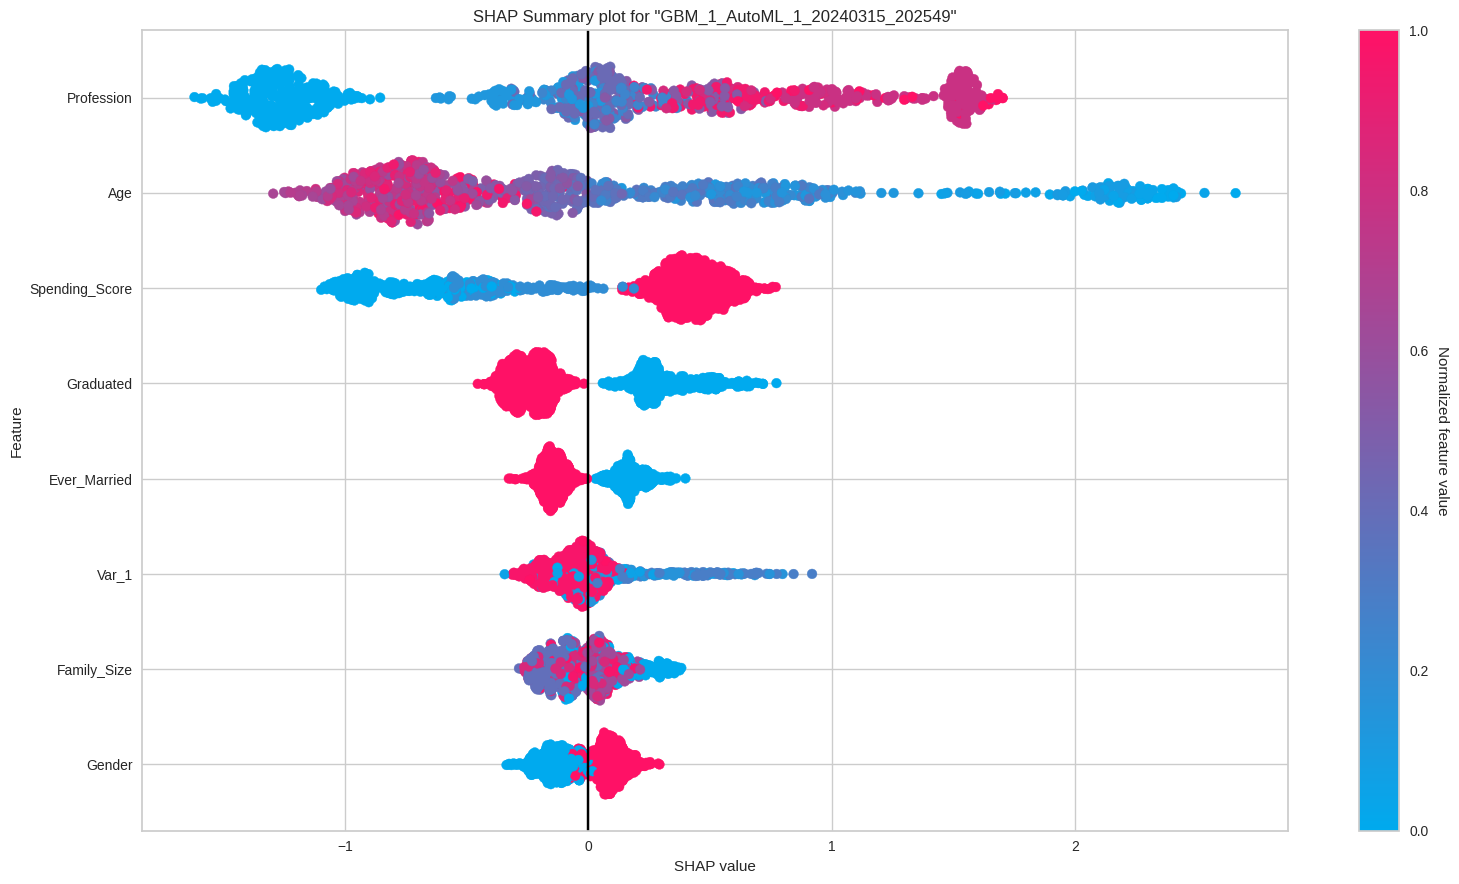

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

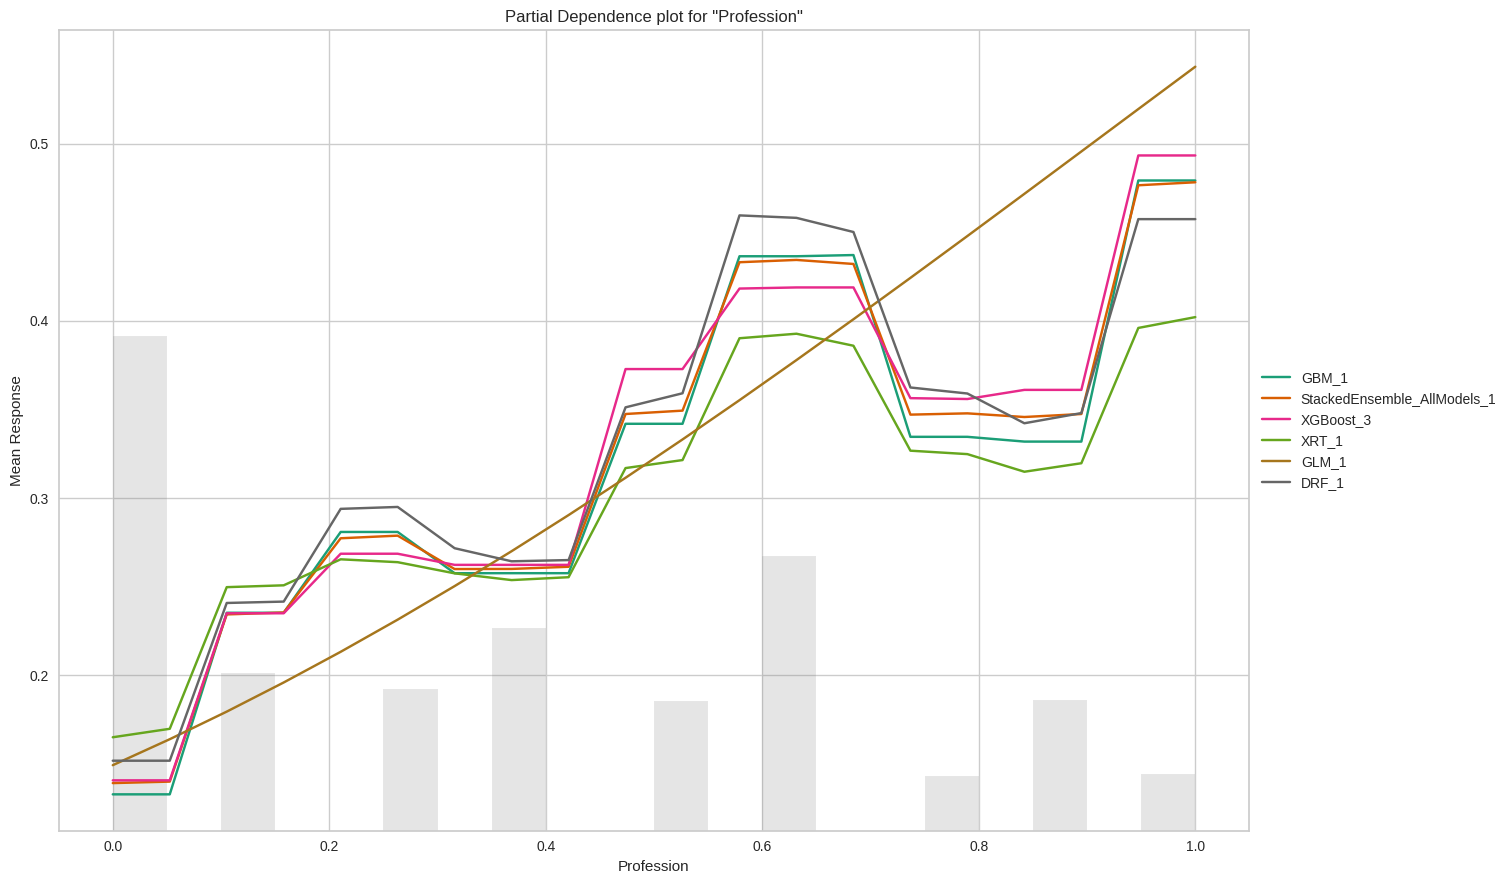

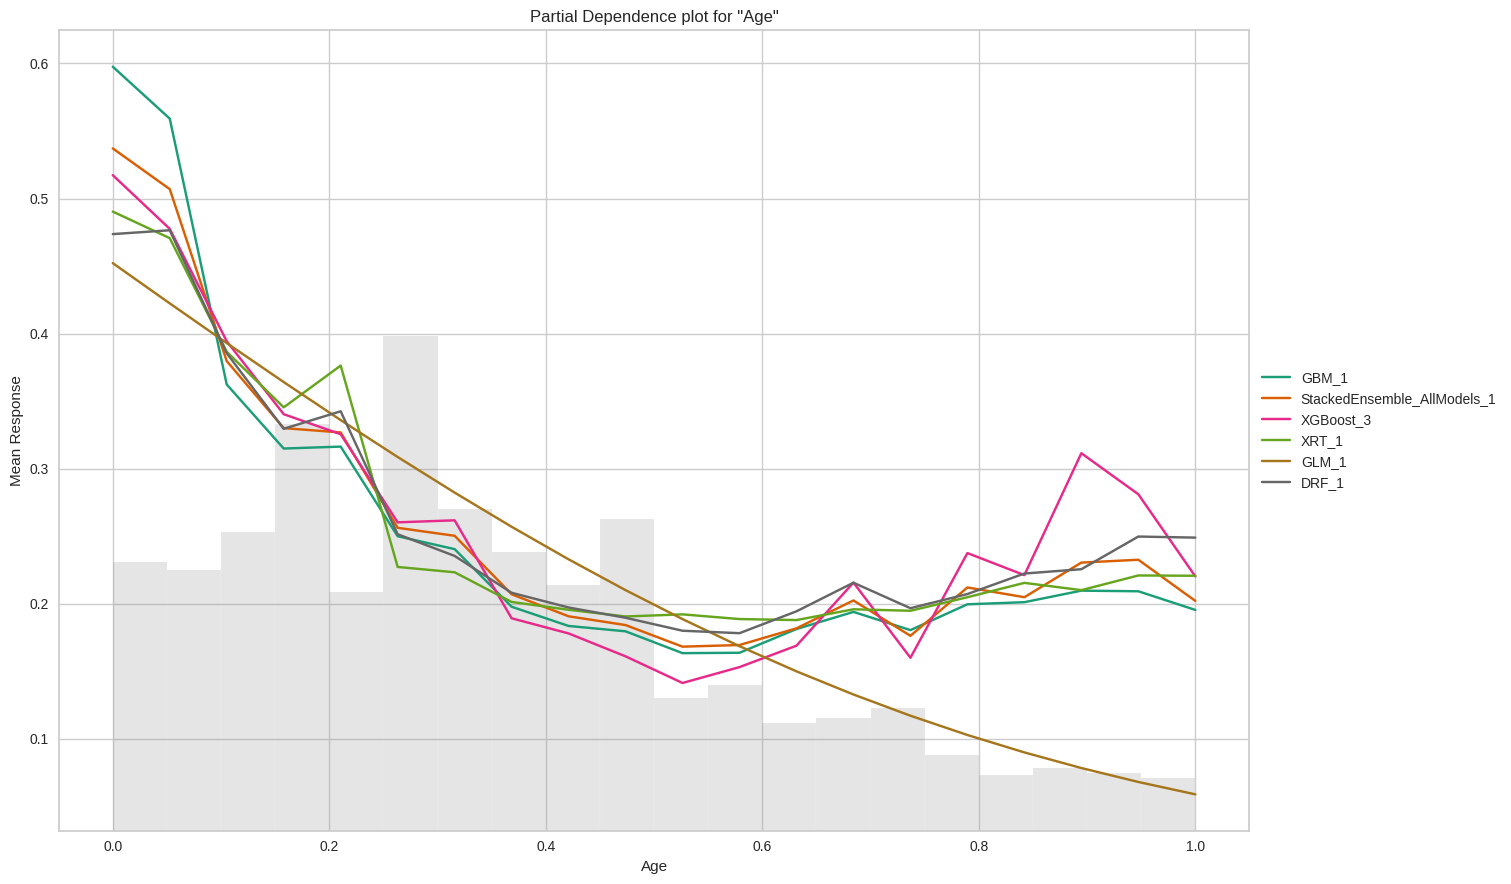

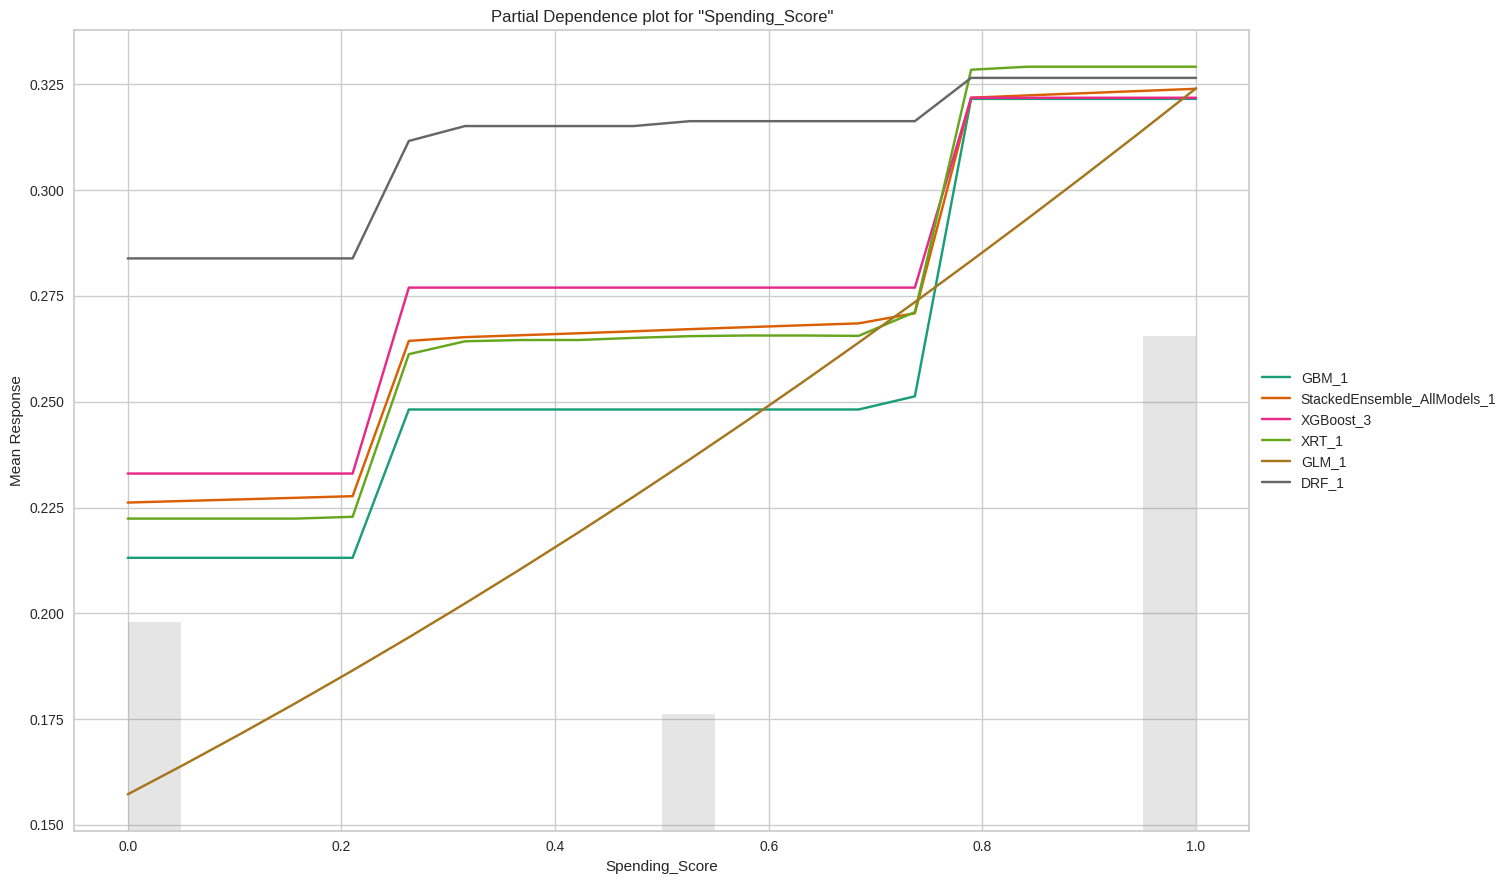

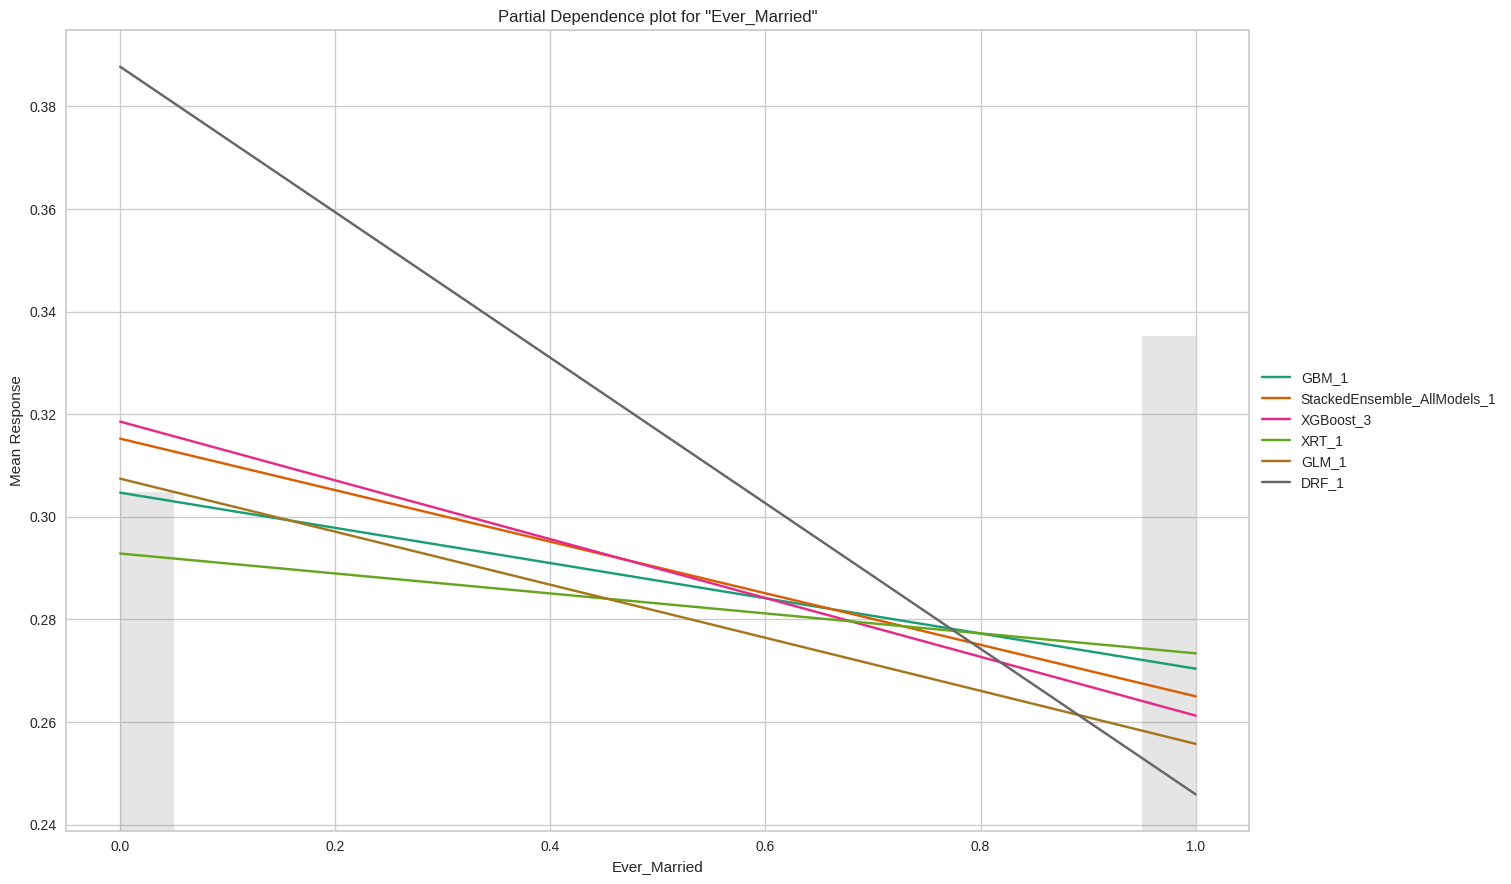

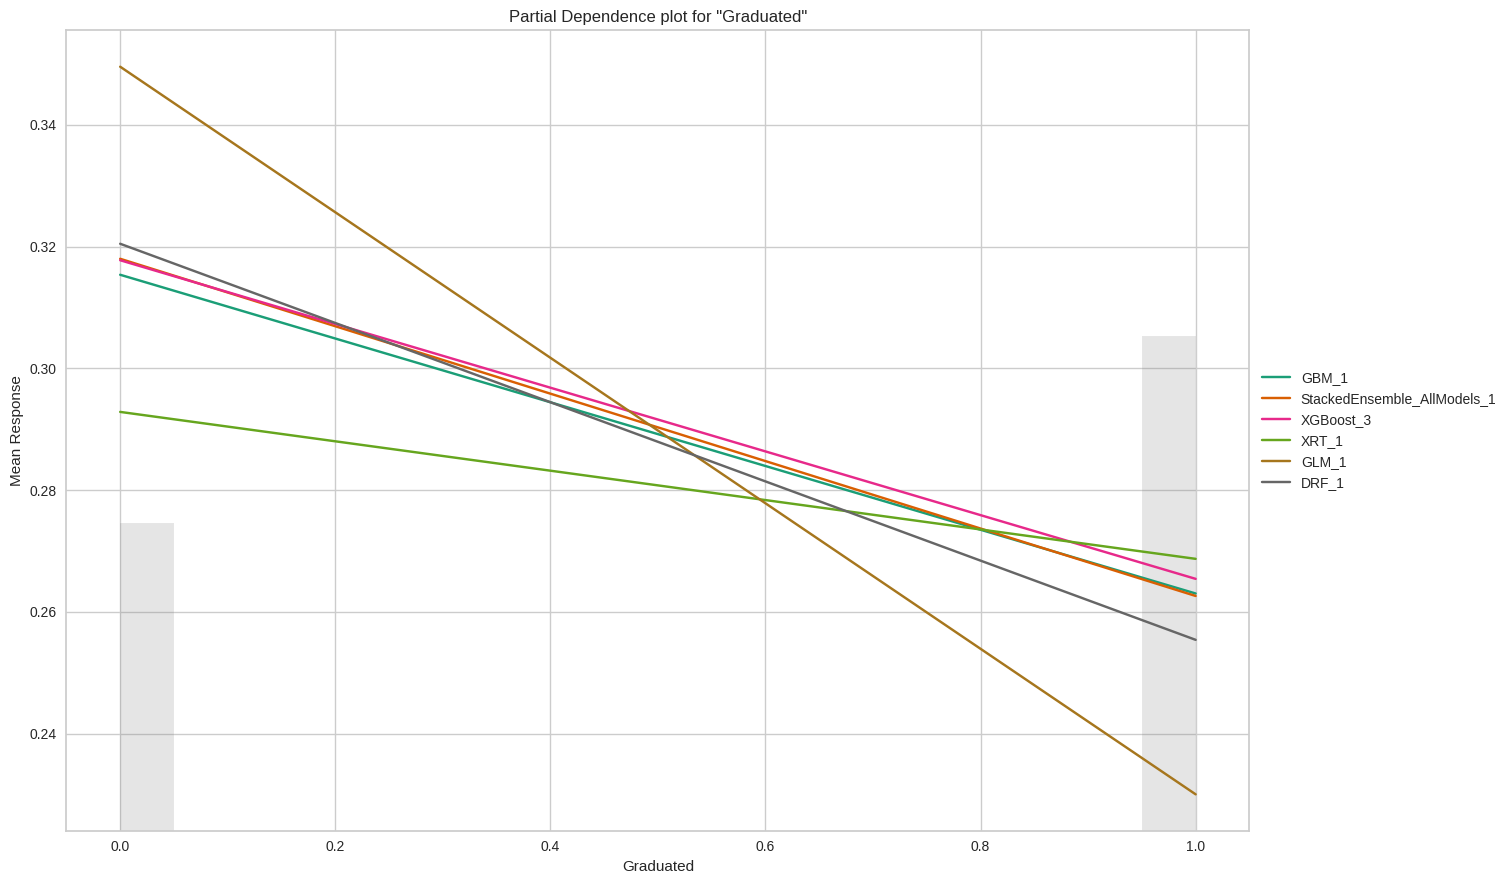

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

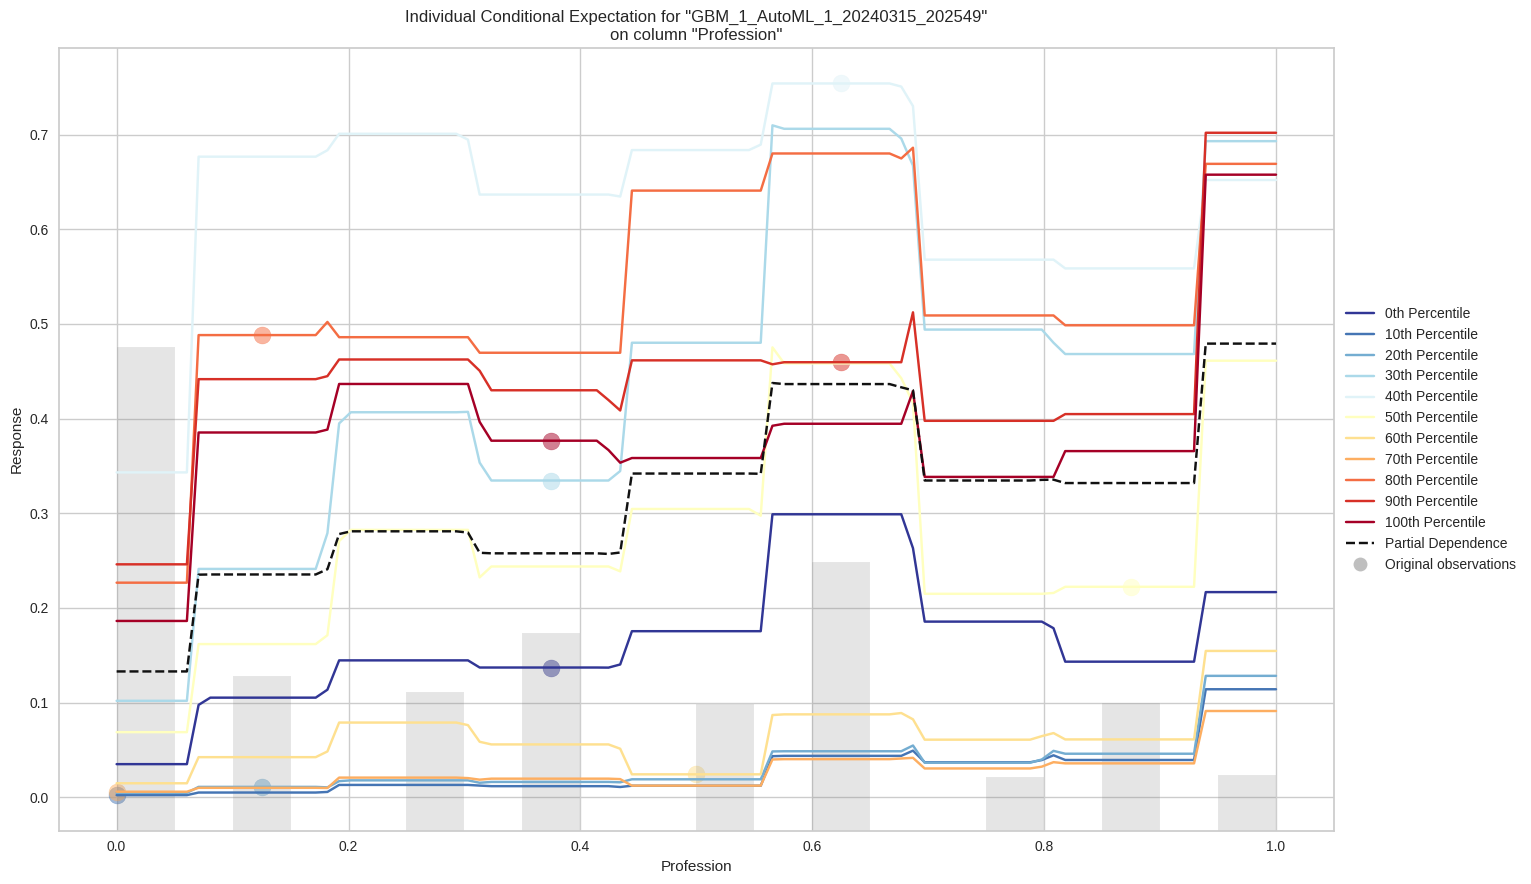

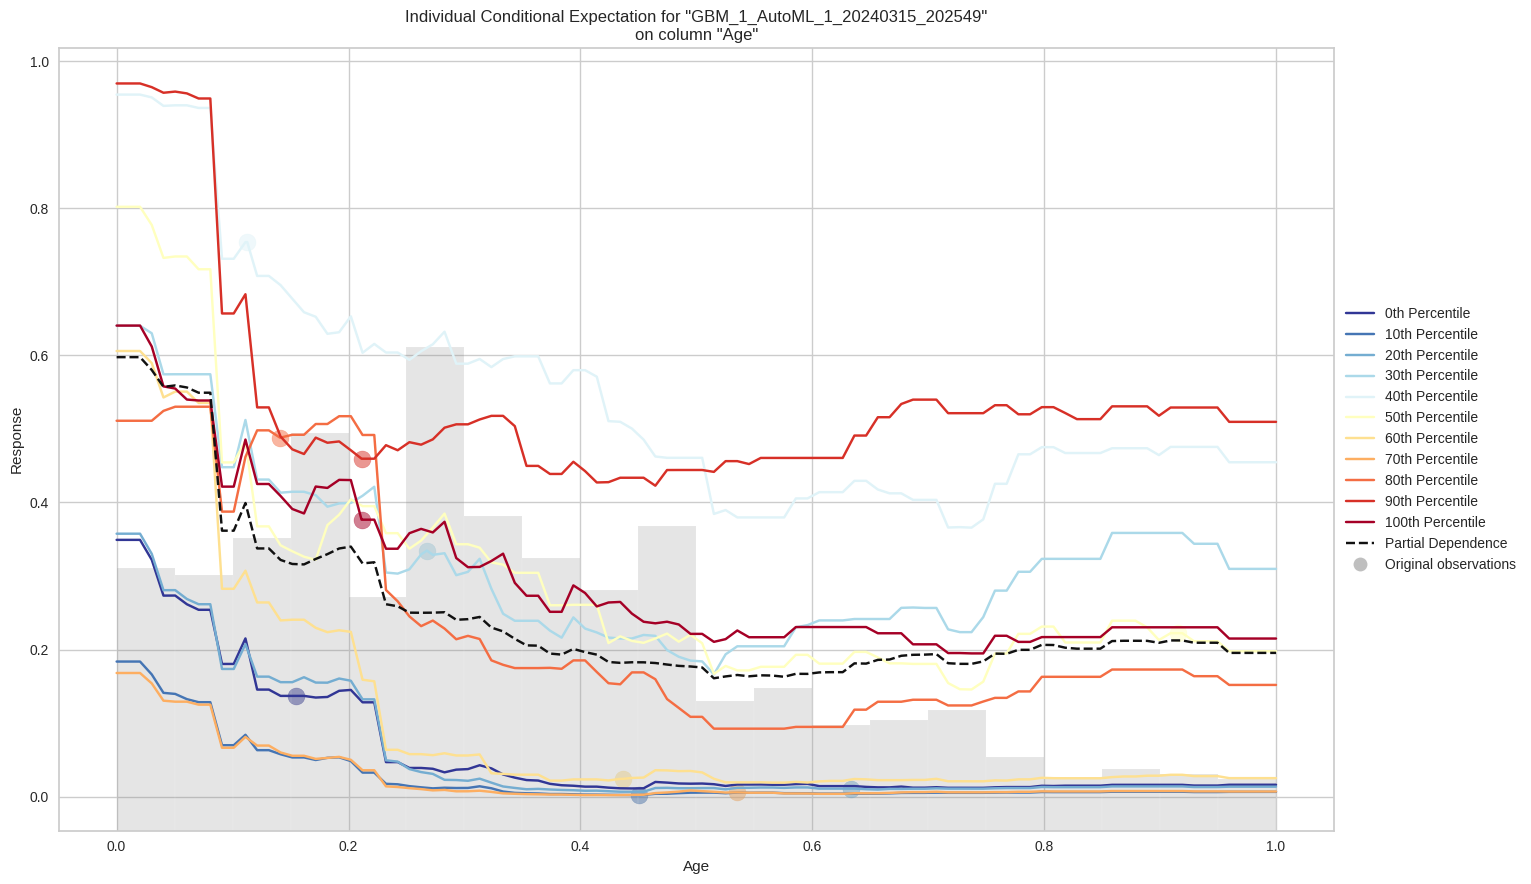

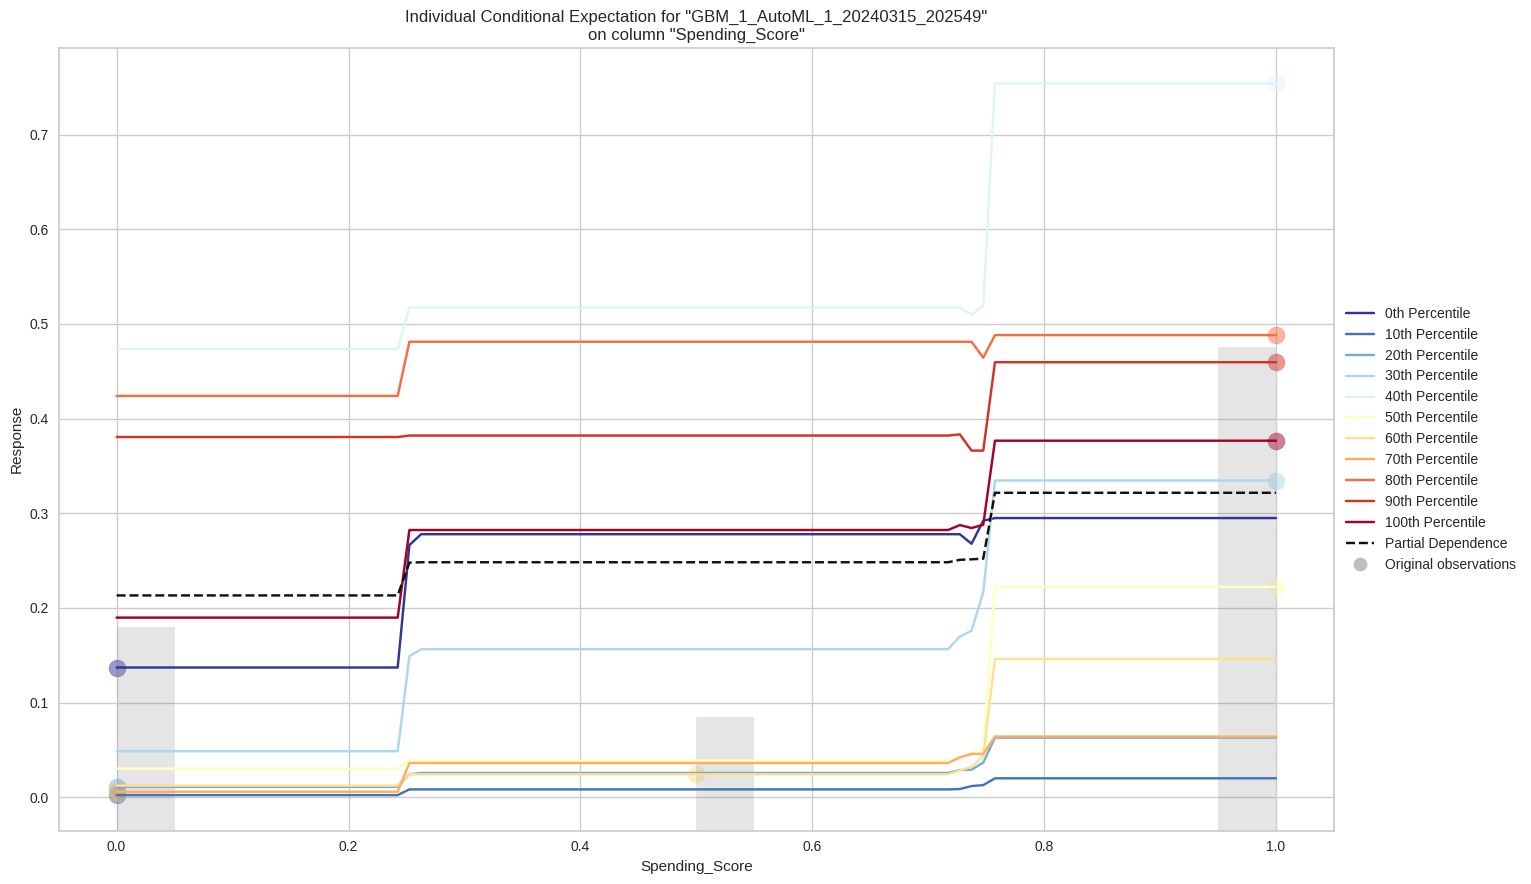

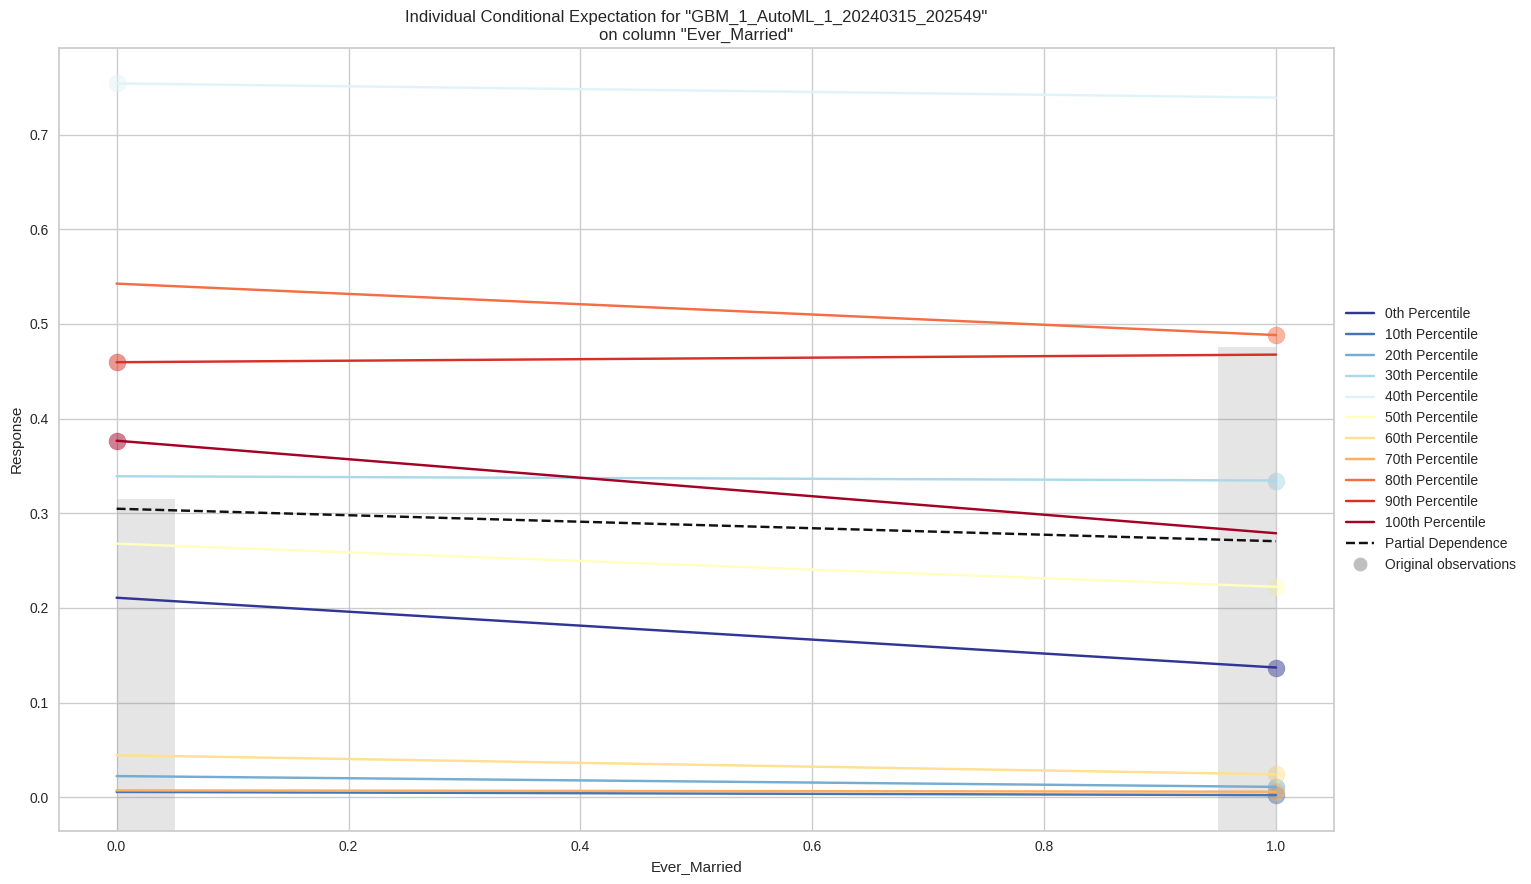

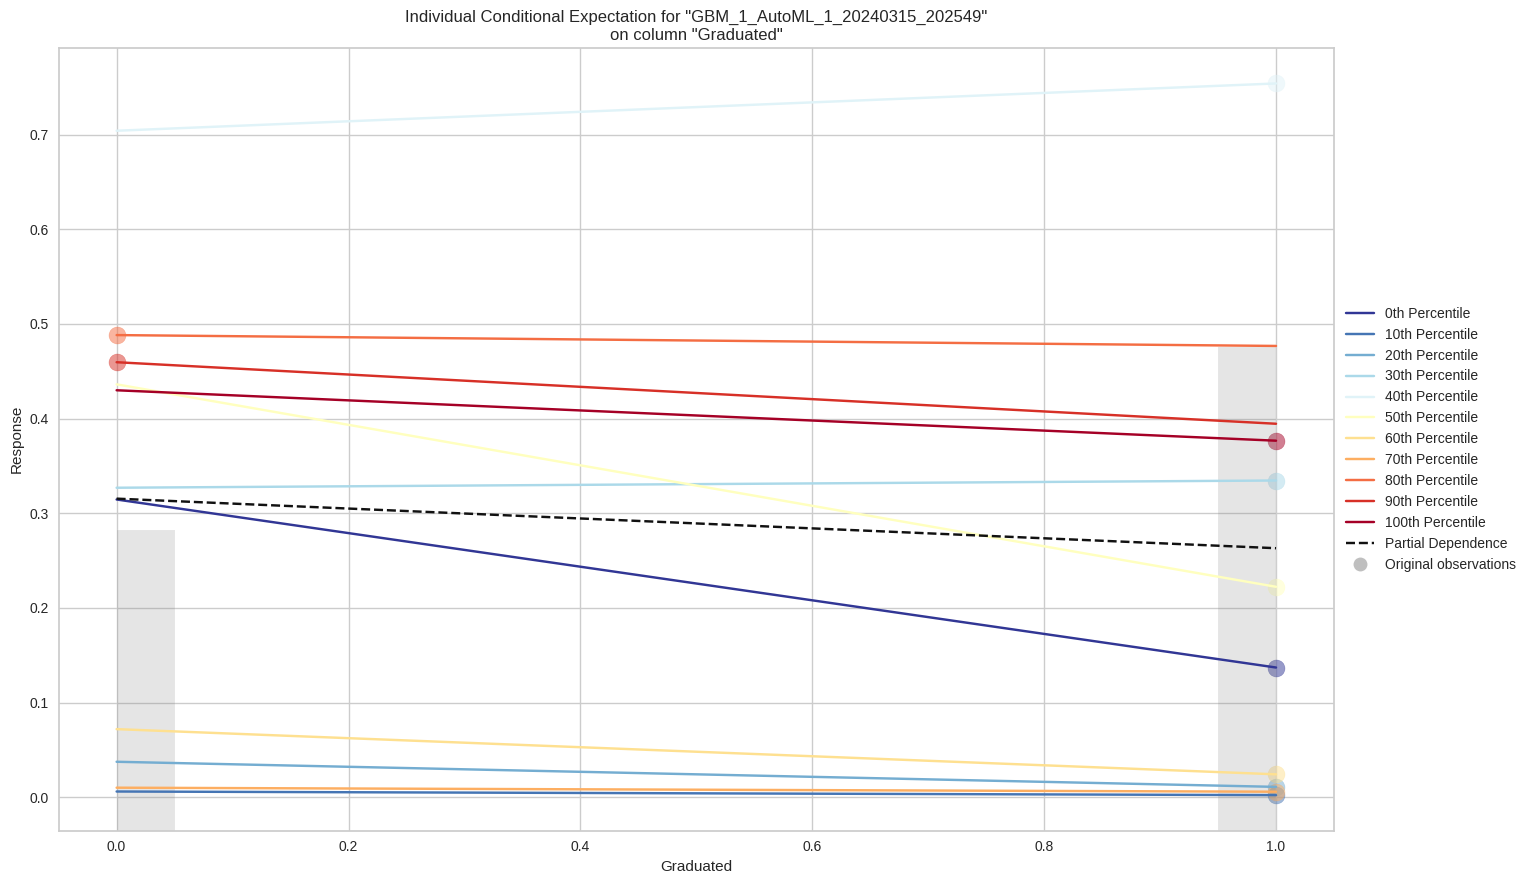

In [103]:
exa = aml.explain(test_hf)

# CONCLUSION

For this dataset the best model according to AutoML is gbm. When a classifier like Random Forest was implemented on this dataset it gave a better accuracy. The accuracy on training data was 78.6 percent. On the other hand when Linear Regression was implemented the accuracy for training data was 13.6 percent. After implementing these model I calculated SHAP values using SHAP analysis method. I plotted different plots like permutation plots, waterfall plot, feature importance bar chart and many more plots.

For each model, the important feature obtained were different. Among all these 3 models the best accuracy was obtained for random forest model.The important features for this model were Profession, Age, Family_Size. This means that for this model the target variable 'Segmentation' is highly depended on Profession, Age, Family_Size.

# REFERENCES
H20.ai- https://docs.h2o.ai/

GitHub Notebook: https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Smoke_Detection_Example.ipynb

GBM Model- https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html

GBM theory: https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

Model Evaluation: https://piml.medium.com/gbm-model-evaluation-beyond-prediction-accuracy-397248b5cef0

GitHub Notebook: https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/CC_Kaggle_AutoML_Regression_Melbourne_Housing.ipynb

Kaggle Notebook- https://www.kaggle.com/code/nyinyeinaung/customer-segmentation-multiclass-classification

Dataset- https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation

# License

MIT License
Copyright (c) 2024 SangramSA

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


